# Spark RDD

* Last updated 20200920SUN1400 20191001_20181201_20171218_20170515_20161125

## S.1 학습내용

### S.1.1 목표

* 파일, JSON 등에서 RDD를 생성할 수 있다.
* map-reduce 등 RDD API를 사용하여 데이터를 변환하고, 분석할 수 있다.
* 텍스트데이터를 단어 빈도, word vector로 변환할 수 있다.

### S.1.2 목차

* S.2 SparkSession
* S.2.1 Spark를 설치한 경우
* S.2.2 pyspark를 설치한 경우
* S.2.3 Spark 설정
* S.3 데이터 구조
* S.4 RDD 소개
* S.5 RDD 생성
* 문제 S-1: 파일에서 RDD 생성하기
* S.6 RDD API 
* S.6.1 비슷한 Python 함수
* S.6.2 RDD 사용하기
* 5.6.3 Pair RDD
* S.7 spark-submit

### S.1.3 문제

* 문제 S-2: RDD를 사용하여 word count를 계산하고 그래프 그리기.
* 문제 S-3: 성적 합계 및 평균.
* 문제 S-4: 서울시 지하철호선별 승차인원 평균 구하기.
* 문제 S-3: RDD를 사용하여 word vector를 생성하기.

## S.2 SparkSession

**Spark 2.0부터는 SparkSession을 시작점**으로 개별적인 Context를 모두 **통합**해서 사용한다.
SparkSession은 빅데이터를 처리하기 위해 구성된 **Spark 클러스터에 대한 클라이언트**와 같은 역할을 하며, 이를 통해 모든 기능을 사용한다.
따라서 클러스터 매니저로부터 CPU, 메모리, 하드웨어 등 시스템 자원을 배분받아서 필요한 작업을 수행하게 된다.

**Spark 2.0 이전에는 SparkContext를 먼저 만들고** 이를 통해 다른 Context를 사용했다. 아래에서 보듯이 Spark 1.x에서는 **SparkContext를 직접 생성**하고, **이를 통해 SQLContext, HiveContext도 생성**하여 사용했다. 이런 방식은 2.x에서도 호환되므로 그대로 사용할 수도 있지만, **SparkSession으로 통합**되었다.

```python
# 버전 1.x
import pyspark
conf=pyspark.SparkConf()
conf = pyspark.SparkConf().setAppName("myAppName")
sc = pyspark.SparkContext(conf=conf)  #SparkContext를 직접 생성한다.
sqlContext = SQLContext(sc)           #SparkContext를 넣어서 SQLContext를 생성
```

Context는 다음과 같이 RDD, DataFrame, 라이브데이터, 데이터베이스에 대해 제공되고 있다.

Context 구분 | 설명 | 사용 예
----------|----------|----------|----------
SparkContext | RDD를 사용하는 Context | SparkSession로부터 SparkContext 생성
StreamingContext | 트위터, Flume, TCP 소켓 등 라이브 데이터 | pyspark.streaming.StreamingContext(sparkConf, Seconds(2)) 2초마다
SQLContext | Spark SQL, DataFrame | spark.sql (1.x에서는 SQLContext(SparkContext))
HiveContext | HiveQL, DataFrame | spark.sql (1.x에스는 HiveContext(SparkContext))

### S.2.1  Spark를 설치한 경우

* 경로 및 라이브러리 추가

Spark를 jupyter notebook에서 사용하려면, 
Spark가 설치된 디렉토리를 SPARK_HOME으로 설정하고, 또한 실행에 필요한 라이브러리를 추가한다.
(Annaconda 문서 "**Configuring Anaconda with Spark**" 참조)
보통 라이브러리 경로는 디렉토리를 지정하게 되지만, **zip**파일도 경로로 추가할 수 있다.

설정 항목 | 설명
----------|----------
SPARK_HOME | Spark가 설치된 경로이다.
PYTHONPATH | sys.path.insert()를 사용하여 'PYTHONPATH'를 수정한다. pyspark.zip, py4j-0.10.x-src.zip를 추가 (버전은 수정해야 함)

In [15]:
!pip install pyspark

In [16]:
!where python

C:\Users\zaqxs\Anaconda2\envs\py35\python.exe
C:\Users\zaqxs\Anaconda2\python.exe
C:\Users\zaqxs\AppData\Local\Programs\Python\Python36\python.exe
C:\Users\zaqxs\AppData\Local\Microsoft\WindowsApps\python.exe


In [1]:
import sys
print(sys.version)

3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]


In [2]:
import os
home=os.path.expanduser("~")
os.environ["PYSPARK_PYTHON"]="C:/Users/zaqxs/Anaconda2/envs/py35/python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"]="C:/Users/zaqxs/Anaconda2/envs/py35/python.exe"
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.9-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

In [25]:
!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.1.2
      /_/
                        
Using Scala version 2.12.10, OpenJDK 64-Bit Server VM, 11.0.12
Branch HEAD
Compiled by user centos on 2021-05-24T04:27:48Z
Revision de351e30a90dd988b133b3d00fa6218bfcaba8b8
Url https://github.com/apache/spark
Type --help for more information.


In [19]:
!python --version

Python 3.7.3


In [20]:
!java --version

openjdk 11.0.12 2021-07-20 LTS
OpenJDK Runtime Environment 18.9 (build 11.0.12+7-LTS)
OpenJDK 64-Bit Server VM 18.9 (build 11.0.12+7-LTS, mixed mode)


In [21]:
!javac --version

javac 11.0.12


In [22]:
import findspark
findspark.find()

'C:\\spark\\spark-3.1.2-bin-hadoop3.2'

In [17]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

* SparkSession 생성

In [3]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

### S.2.2  pypark를 설치한 경우

pyspark를 설치하는 경우에는 Spark가 설치된 경로 SPARK_HOME, Python 라이브러리 경로 PYTHONPATH를 별도로 설정할 필요가 없이 SparkSession을 별도로 생성하면 된다. 또는 Databricks의 Spark Cloud에서는 SparkSession을 미리 생성해 주어서 굳이 생성하지 않아도 된다.
pyspark를 사용하거나 Spark Cloud를 사용해도 SparkSession을 생성해도 된다.

#### pyspark 설치 경로 확인


Python 라이브러리 경로가 방금 추가한 두 개의 zip파일이 잡혀있는 것을 볼 수 있다.
필요한 jars파일은 보통 /python3.6/site-packages/pyspark/jars에 설치가 된다.
```/home/jsl/.local/lib/python3.6/site-packages``` 디렉토리를 찾아보자.
pyspark만 설치해도 필요한 jars가 설치되고, 그렇기 때문에 Spark를 설치하지 않아도 기능을 사용할 수 있게 된다.


In [29]:
import sys
for i in sys.path:
    print(i)

C:\spark\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip
C:\spark\spark-3.1.2-bin-hadoop3.2\python\lib\py4j-0.10.9-src.zip
C:\spark\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip
C:\spark\spark-3.1.2-bin-hadoop3.2\python\lib\py4j-0.10.9-src.zip
C:\spark\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip
C:\spark\spark-3.1.2-bin-hadoop3.2\python\lib\py4j-0.10.9-src.zip
C:\Users\zaqxs\Code\201910787\s-master
C:\Users\zaqxs\Anaconda2\envs\py35\python37.zip
C:\Users\zaqxs\Anaconda2\envs\py35\DLLs
C:\Users\zaqxs\Anaconda2\envs\py35\lib
C:\Users\zaqxs\Anaconda2\envs\py35

C:\Users\zaqxs\Anaconda2\envs\py35\lib\site-packages
C:\Users\zaqxs\Anaconda2\envs\py35\lib\site-packages\win32
C:\Users\zaqxs\Anaconda2\envs\py35\lib\site-packages\win32\lib
C:\Users\zaqxs\Anaconda2\envs\py35\lib\site-packages\Pythonwin
C:\Users\zaqxs\Anaconda2\envs\py35\lib\site-packages\IPython\extensions
C:\Users\zaqxs\.ipython


#### Python 2, 3이 같이 설정되어 있는 경우

자신의 PC에 복수의 파이썬 2.x, 3.x 버전이 설치되어 있는 경우, 어느 버전을 사용해야 하는지 환경변수를 설정해서 실행 경로를 지정해주어야 한다.
* PYSPARK_PYTHON는 workers/executors가 사용하는 버전
* PYSPARK_DRIVER_PYTHON: driver가 사용하는 버전

spark를 생성한 후, 환경변수를 다시 설정해주면 Kernel을 재시작해야 한다.

In [26]:
import os
home=os.path.expanduser("~")
os.environ["PYSPARK_PYTHON"]="C:/Users/zaqxs/Anaconda2/envs/py35/python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"]="C:/Users/zaqxs/Anaconda2/envs/py35/python.exe"
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.9-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

#### SparkSession 생성


Spark를 사용하려면 ```SparkSession``` 객체를 생성해야 한다.

SparkSession을 생성해 보자. SparkSesion은 sql 모듈로 **'pyspark.sql.SparkSession'**을 클라이언트로 사용한다.
필요한 설정은 SparkSession이 만들지기 전에 해 두어야 한다. 여기서는 설정을 별도로 하지 않고 비워 놓았다.
SparkSession은 **builder.getOrCreate()** 함수를 호출하여, 기존의 session 또는 새로 생성하여 사용한다. 함수 **getOrCreate()** 함수는 **singleton 패턴**으로 한 번에 하나의 세션만이 존재하도록 한다.
SparkSession을 종료하려면 stop() 함수를 호출한다.

```python
spark = pyspark.sql.SparkSession.builder.getOrCreate()
spark.stop()
```

Spark를 실행하기 전 **필수적**으로 설정해야 하는 항목은
* **master**: (1) 분산의 경우 master URL 또는 (2) 로컬인 경우 ```local[]```라고 적어준다.
즉 local의 수는 CPU core의 수를 의미한다. 예를 들어 ```local[*]```는 가능한 최대한의  core를 사용한다는 의미이다.
예를 들어, local[5]라고 하면, core의 수가 2개라고 하더라도 데이터는 5개의 partitions로 나누어져 주어진다.
    * ```local```은 Spark를 로컬에서 실행한다는 의미이다.
    * ```local[n]```는 worker의 쓰레드를 n개로 한다는 의미. CPU core의 개수에 맞추어 설정하자.
    * ```local[*]``` 는 가능하면 가용한 모든 쓰레드를 사용한다는 의미 (Runtime.getRuntime.availableProcessors()로 그 수를 알 수 있다)
* **appName**: 앱의 이름

In [1]:
import pyspark

ImportError: cannot import name 'print_exec' from 'pyspark.cloudpickle' (C:\Users\zaqxs\Anaconda2\envs\py35\lib\site-packages\pyspark\cloudpickle\__init__.py)

In [2]:
import pyspark

myConf=pyspark.SparkConf()
myConf=pyspark.SparkConf().set("spark.driver.bindAddress", "127.0.0.1")
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

ImportError: cannot import name 'print_exec' from 'pyspark.cloudpickle' (C:\Users\zaqxs\Anaconda2\envs\py35\lib\site-packages\pyspark\cloudpickle\__init__.py)

### S.2.3 Spark 설정

몇 가지 설정을 확인해 보자.
설치디렉토리 아래 ```conf/```에 있는 spark-defaults.conf와 같은 설정파일에 자신에게 필요한 설정을 해 놓으면 된다.

In [ ]:
print ("Spark version \t: {}".format(spark.version))
print ("Spark App \t: {}".format(spark.conf.get('spark.app.name')))
print ("Spark Master \t: {}".format(spark.conf.get('spark.master')))
print ("Spark Host \t: {}".format(spark.conf.get('spark.driver.host')))

#### spark-warehouse

spark-warehouse는 내부적으로 사용되는 디렉토리로서, Derby 데이터베이스 관련 파일을 저장하게 된다.
이 디렉토리는 Spark를 실행하면 **작업 디렉토리 아래 자동으로 생성**된다.
또는 ```/conf/hive-site.xml``` 파일에 spark.sql.warehouse.dir를 설정해도 된다.
또는 실행하면서 추가할 수도 있다. (참고: hdfs 파일형식으로 ```file:///```을 추가)

```python
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config("spark.sql.warehouse.dir", "C:/Users/jsl/myTemp")\
    .getOrCreate()
```

spark-warehouse 디렉토리는 conf.get() 함수로 알아볼 수 있다. 다음에서 보듯이, ```usr.dir``` 밑에 spark-warehous가 만들어졌다는 의미이다.
Java Property에 따르면 ```user.dir```는 사용자 작업디렉토리, user working directory이다. ```user.home```은 홈 디렉토리이다.

In [ ]:
spark.conf.get('spark.sql.warehouse.dir')

#### 모든 설정

spark 2.1이상에서는 아래와 같이 설정을 dictionary 형식으로 읽을 수 있다.

In [ ]:
spark.sparkContext.getConf().getAll()

In [ ]:
spark.sparkContext._conf.getAll()

#### 설정의 변경

SparkSession이 일단 만들어지고 나서는, sparkContext를 경유해서 ```spark.sparkContext._conf.set()``` 함수로 설정을 변경할 수 있다.

java.net.BindException이 발생한 경우
process를 죽이거나, 로컬주소가 바인딩이 되어있지 못해서 그렇다.

In [ ]:
spark.sparkContext._conf.set("spark.driver.bindAddress", "127.0.0.1")

In [ ]:
spark.sparkContext._conf.set("spark.executor.memory", '8g')
spark.sparkContext._conf.set('spark.app.name', 'jsl')
spark.sparkContext._conf.set('spark.executor.cores', '3')
spark.sparkContext._conf.set('spark.cores.max', '3')
spark.sparkContext._conf.set("spark.driver.memory",'8g')

In [ ]:
spark.sparkContext._conf.getAll()

Spark를 실행하면서 라이브러리를 설정해야 할 필요도 생겨나게 된다. 다음은 mongo, graphframes, csv 등의 라이브러리가 설정되어 있는 내용을 보여주고 있다. 라이브러리는 https://spark-packages.org 를 방문해서 찾아서 사용하면 된다. 실제로 설치하지 않고, 명명규칙에 따라, maven에서 하는 것과 같이, 콜론으로 구분해, 패키지명과 라이브러리를 버전정보와 같이 적어주면 된다.

"spark.jars"는 컴마로 구분된 jar 파일 목록으로 classpath로 설정된다.

In [ ]:
SparkHOME=os.path.join(os.environ['SPARK_HOME'], "C:\spark\spark-3.1.2-bin-hadoop3.2")
jars = [os.path.join(SparkHOME, x) for x in os.listdir(os.path.join(SparkHOME, "jars"))]

In [ ]:
print(jars[0:5])

In [ ]:
spark.sparkContext._conf.set('spark.jars', jars)    

In [ ]:
spark.sparkContext._conf.getAll()

## S.3 데이터 구조

Spark에서는 RDD, Dataframe, DataSet 세 가지 데이터구조를 제공하고 있다. 이 가운데 **RDD API에 대한 지원은 축소**되고 있다.
* **RDD**는 Spark 1.0부터 사용되었고, 이를 기반으로 다른 데이터구조가 만들어졌다. RDD는 데이터가 **비구조적**인 경우 사용하기 적합하다. 모델schema를 정하지 않고 사용할 수 있다.
* **Dataframe**은 버전 1.3에서 제공되어 많이 쓰이고 있다. DataFrame과 DataSet은 데이터가 schema와 데이터타잎을 가진 **구조적**인 경우 사용한다.
* **DataSet**은 그 후 1.6부터 제공하고 있다.

데이터구조 | 언제 Spark에 도입 | 설명
---------|---------|---------
**RDD** | 1.0 | **비구조적**, schema free, low-level
**Dataframe** | 1.3 | **구조적**, schema를 가진다. Dataset[Row]와 같은 의미로, 타잎을 강제하지 않는다.
**Dataset** | 1.6 | 자바의 Generic과 같이 Dataset[T]으로 '타잎'을 강제하는 형식이다. Scala and Java에서 사용한다. Python loosely-typed이므로 사용하지 않는다.

* Spark의 RDD, DataFrame 모두 immutable이라 일단 생성되고 나면 원본을 수정할 수 없다.
* Spark의 데이터는 모두 **lazy**, 실제 transformation을 action까지 연기한다. **변환할 때마다 실제 변환이 일어나면 그 결과가 메모리에 저장되는 비효율성**을 막기 위해, **action이 실행되는 경우, 계산이 이루어지고, 실제 메모리를 사용**한다. RDD의 경우, action이 실행될 때마다 재계산이 이루어지는 것을 막기 위해 persist (or cache)함수를 사용할 수 있다.


## S.4 RDD 소개

RDD (Resilient Distributed Dataset)는 그 줄임말에서 알 수 있듯이 **데이터를 저장하고 있는 DataSet**이며, 여러 컴퓨터에 **분산**해서 사용해서 사용할 수 있다는 점이 특징이다.
* Resilient - 작업이 실패하지 않도록 fault tolerent, 즉 어느 한 노드에서 작업이 실패하면 다른 노드에서 실행
* Distributed - 클라스터로 구성된 여러 노드에 분산해서 처리
* Dataset - 데이터 구조

RDD는 Python List, 파일, hdfs 등 다양한 자료에서 생성할 수 있고, 생성된 자료는 수정할 수 없는 read-only이다.

## S.5 RDD 생성

RDD는 **sparkContext**로부터 만들어 진다.
* 1) 이미 만들어진 배열과 같에서 읽어서 생성한다. 이 경우 parallelize() 함수를 사용하게 된다.
* 2) 또는 파일, 데이터베이스 등 외부에서 읽어서 생성할 수도 있다. textFile() 함수를 사용한다.

생성 방법 | 설명 | 함수
----------|----------|----------
내부에서 읽기 | Pytho list에서 생성 | parallelize()
외부에서 읽기 | 파일, HDFS, HBase 등 | ```textFile("mydir/")```<br>```textFile("mydir/*.txt")```<br>```textFile("mydir/*.gz")```<br>```Hadoop InputFormat```


### List에서 RDD 생성하기

```sparkContext.parallelize()``` 함수를 사용하여 Python list에서 RDD를 생성할 수 있다.

In [3]:
myList=[1,2,3,4,5,6,7]

In [4]:
myRdd1 = spark.sparkContext.parallelize(myList)

NameError: name 'spark' is not defined

take(number)는 num만큼의 줄을 출력한다.

In [ ]:
myRdd1.take(3)

In [ ]:
spark.sparkContext.parallelize([0, 2, 3, 4, 6], 2).collect()

* glom()

```parallelize([1,2,3,4,5,6,7], 2)```와 같이 slice 개수를 정할 수 있다.
glom() 함수는 각 partition에 있는 요소를 묶어서 RDD 만들어 준다.
아래 예제에서 보듯이 [1,2,3,4,5,6,7]을 2개의 slice로 분할하고, RDD로 만들어 주고 있다.

In [ ]:
spark.sparkContext.parallelize([1,2,3,4,5,6,7], 2).glom().collect()

### 파일에서 RDD 생성하기

파일에서 직접 RDD를 생성해 본다.
현재 작업 디렉토리 아래에 **'data/' 디렉토리**를 만들고 아래 파일을 생성한다.
파일 내용은 wikipedia에서 Apache spark를 검색한 후 첫 문단을 복사해서 가져 왔다.
일부러 3째줄은 한글, 4째 줄은 같은 단어를 반복해서 추가했다.

In [5]:
%%writefile data/ds_spark_wiki.txt
Wikipedia
Apache Spark is an open source cluster computing framework.
아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.
Apache Spark Apache Spark Apache Spark Apache Spark
아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크
Originally developed at the University of California, Berkeley's AMPLab,
the Spark codebase was later donated to the Apache Software Foundation,
which has maintained it since.
Spark provides an interface for programming entire clusters with
implicit data parallelism and fault-tolerance.

Overwriting data/ds_spark_wiki.txt


파일에서 RDD를 생성하기 위해서는 앞서와 같이 SparkContext를 사용한다.
파일명을 textFile() 함수 인자로 넣어서 만들어 주면 된다.

In [6]:
myRdd2=spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_wiki.txt"))

NameError: name 'spark' is not defined

```first()```는 첫 데이터만 조회하는 action함수이다.
first()은 take(1)과 동일한 결과를 출력하는데, 그 이유는 first()는 내부적으로 take(1) 함수를 사용하기 때문이다.

In [ ]:
myRdd2.first()

#### RDD와 Spark Dataframe를 만드는 함수는 서로 다르다

DataFrame은 다음 장에서 배우게 되겠지만, file에서 읽는 방식이 RDD와 Dataframe이 서로 다르다.
RDD는 sparkContext.textFile(), Dataframe은 read.text()을 사용한다.

구분 | 설명
-----|-----
SparkSession.sparkContext.textFile() | **'SparkContext'를 사용하므로 RDD를 생성**한다.
SparkSession.read.text() | **DataFrame을 생성**한다.

In [ ]:
import os
myDf=spark.read.text(os.path.join("data", "ds_spark_wiki.txt"))
print (myDf.first())

읽고 생성된 변수 myDf의 데이터타입을 type()으로 확인하면 DataFrame이다.

In [ ]:
print (type(myDf))

#### csv에서 RDD 생성하기

csv 파일은 컴마로 구분된 데이터를 저장하고 있다. 이 파일을 읽어서 RDD를 생성해 보자.

In [22]:
%%writefile ./data/ds_spark_2cols.csv
35, 2
40, 27
12, 38
15, 31
21, 1
14, 19
46, 1
10, 34
28, 3
48, 1
16, 2
30, 3
32, 2
48, 1
31, 2
22, 1
12, 3
39, 29
19, 37
25, 2

Overwriting ./data/ds_spark_2cols.csv


파일에서 읽어 RDD를 생성할 수 있다.

In [23]:
myRdd4 = spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_2cols.csv"))

```take()```를 하면 그 결과는 리스트가 된다.
아래에서 보듯이 파일의 각 라인이 묶여서 리스트의 한 요소로 만들어진다.

In [24]:
myList=myRdd4.take(5)
print (type(myList))

<class 'list'>


## 문제: 파일에서 RDD 생성

다음 링크에서 파일을 읽어서 RDD를 생성하고, 5줄을 화면출력하세요.

* 1) 경기도 의정부시 인구현황 (파일명: ```경기도 의정부시_인구현황_20200904```)
https://www.data.go.kr/data/15009613/fileData.do

* 2) 제주특별자치도 서귀포시 내 연도별 65세이상 인구수 및 고령화비율, 노령화지수 현황 (파일명: ```제주특별자치도 서귀포시_고령화비율및노령화지수현황_20200623```)
https://www.data.go.kr/data/15051545/fileData.do

### 주의:

* SparkSession은 한 번만 생성하면 된다. 파일을 2번 읽는다 하더라도, SparkSession은 세션 동안 1회만 생성하면 된다.
* 파일을 읽을 경우, 문자가 한글인지, 영어인지 어떻게 인코딩되었는지 주의해야 한다. 결과가 깨져보인다면, 그 이유를 간단히 적으세요.

### SparkSession 생성

In [12]:
import sys
print(sys.version)

3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]


In [16]:
import os

home=os.path.expanduser("~")
os.environ["PYSPARK_PYTHON"]="C:Users/zaqxs/Anaconda2/envs/py35/python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"]="C:/Users/zaqxs/Anaconda2/envs/py35/python.exe"
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.9-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

In [17]:
import os
import pyspark

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

ImportError: cannot import name '_parse_memory' from 'pyspark.util' (C:\Users\zaqxs\Anaconda2\envs\py35\lib\site-packages\pyspark\util.py)

### RDD로 읽기

In [ ]:
popRdd = spark.sparkContext\
    .textFile(os.path.join("data","경기도 의정부시_인구현황_20200904.csv"), use_unicode=True)

In [ ]:
popRdd.take(5)

In [ ]:
for i in popRdd.take(5):
    print(i)

화면에 출력하면 한글이 깨져있다. ```use_unicode=True```설정을 주었는데도 그렇다.
다운로드 받으면서 한글이 깨져 있기 때문에 그렇다. 다운로드 받은 파일을 수정해서 출력하면 된다.

In [ ]:
agedRdd = spark.sparkContext\
    .textFile(os.path.join("data","제주특별자치도 서귀포시_고령화비율및노령화지수현황_20200623.csv"), use_unicode=True)

In [ ]:
for i in agedRdd.take(5):
    print(i)

### binaryFiles

binaryFiles()는 이진파일을 읽는 함수이다.

In [ ]:
popRddBin = spark.sparkContext.binaryFiles(os.path.join("data","경기도 의정부시_인구현황_20200904.csv"))

In [ ]:
_my = popRddBin.map(lambda x :x[1].decode('euc-kr'))

In [ ]:
_my.take(1)

RDD binaryFiles로 읽으니, 파일의 전체내용을 하나의 값으로 읽을 뿐만 아니라,
2차원 배열로 읽어도 행렬의 구조가 없어서 이해하기 어렵다.
인덱스를 변경해서 데이터를 읽어 보자.

In [ ]:
popList = _my.map(lambda x: x.split()).take(3)
popList[0][1]

### DataFrame

데이터를 읽어서 DataFrame을 만드려면 read() 함수를 사용한다.
폰트를 변경하거나 ```option("charset", "euc-kr")```, 헤더를 읽을지 ```option("header", "true")``` 설정을 변경할 수 있어 RDD보다 편리하다.

In [ ]:
popDf = spark\
            .read.option("charset", "euc-kr")\
            .option("header", "true")\
            .csv(os.path.join("data","경기도 의정부시_인구현황_20200904.csv"))

In [ ]:
popDf.show(5)

In [ ]:
agedDf = spark\
            .read.option("charset", "euc-kr")\
            .option("header", "true")\
            .csv(os.path.join("data","제주특별자치도 서귀포시_고령화비율및노령화지수현황_20200623.csv"))

In [ ]:
agedDf.show(5)

### spark-submit 실행

위 프로그램을 ```.py```로 저장하고, ```spark-submit``` 명령으로 배치 실행을 할 수 있다.

In [ ]:
%%writefile src/ds3_popCsvRead.py
#!/usr/bin/env python3
# -*- coding: UTF-8 -*-
import os
import pyspark

def doIt():
    print ("---------RESULT-----------")
    popDf = spark\
                .read.option("charset", "euc-kr")\
                .option("header", "true")\
                .csv(os.path.join("data","경기도 의정부시_인구현황_20200904.csv"))
    popDf.show(5)
    agedDf = spark\
                .read.option("charset", "euc-kr")\
                .option("header", "true")\
                .csv(os.path.join("data","제주특별자치도 서귀포시_고령화비율및노령화지수현황_20200623.csv"))
    agedDf.show(5)

if __name__ == "__main__":
    os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
    os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()
    doIt()
    spark.stop()

In [ ]:
!spark-submit src/ds3_popCsvRead.py

## S.6 RDD API

앞서 RDD를 생성하여 보았다.
이제는 RDD라는 데이터구조에서 데이터를 읽고 변환하고 분석하여 보자.
RDD는 **데이터 변환Transformations**, **연산Actions**으로 구분할 수 있다.
다음에 배우게 될 **Dataframe**의 **Transformer**, **Estimator**와 비교될 수 있다.

### 변환 **transformations**

변환함수는 **lazy연산**을 한다. 실제 변환은 action이 수행되는 시점까지 늦추어져서 이루어진다.
변환 결과는 RDD 또는 seq(RDD)로 만들어진다.

함수 | 설명 | 예제
-------|-------|-------
```map(fn)``` | 요소별로 fn을 적용해서 결과 RDD 돌려줌 | ```.map(lambda x: x.split(' ')```
```filter(fn)``` | 요소별로 선별하여 fn을 적용해서 결과 RDD 돌려줌 | ```.filter(lambda x: "Spark" in x)```
```flatMap(fn)``` | 요소별로 fn을 적용하고, flat해서 결과 RDD 돌려줌 | ```.flatMap(lambda x: x.split(' '))```
```groupByKey()``` | key를 그룹해서 iterator를 돌려줌. |

### **actions**

RDD를 값으로 변환하는데, 보통 Python 리스트가 생성된다.

함수 | 설명 | 예제
-------|-------|-------
```reduce(fn)``` | 요소별로 fn을 사용해서 줄여서 결과 list를 돌려줌 | ```reduce(lambda x,y:x+y)```
```collect()``` | 모든 요소를 결과 list로 돌려줌 |
```count()``` | 요소의 갯수를 결과 list로 돌려줌 |
```take(n)``` | ```collect()```는 전체이지만, n개만 돌려줌 | ```take(1)```
```countByKey()``` | key별 갯수를 세는 함수 | ```countByKey().items()```
```foreach(fn)``` | 각 데이터 항목에 함수fn을 적용 |

###  S.6.1 우선 Python 함수로 해보기

#### map()함수를 사용하지 않고 해보기

map()을 사용하지 않고 섭씨를 화씨로 변환하는 **c2f()**함수를 만들어 보자.
* 데이터를 하나씩 읽어 **for문으로 처리하고, 리스트로 만들어 반환**한다.
* 나중에 **map()함수를 사용하면 for문이 없어도** 가능하다.

In [1]:
celsius = [39.2, 36.5, 37.3, 37.8]
def c2f(c):
    f=list()
    for i in c:
        _f=(float(9)/5)*i + 32
        f.append(_f)
    return f

print (c2f(celsius))

[102.56, 97.7, 99.14, 100.03999999999999]


#### map() 함수를 사용해 보기

Python은 map(), reduce(), filter() 함수를 이미 가지고 있다.
Python map()을 사용해 보자. **for문이 사라진다**는 점에 유의한다.
반복문이 외관상으로는 보이지 않지만, map() 함수 내부적으로 실행된다는 점에 유의하자.
**map() 함수의 인자는 2개** 이다.
* (1) 첫째 인자는 **처리 함수**이고, **함수의 return은 반드시 있어야** 한다,
* (2) 두 번째 인자는 **처리하려는 데이터**이다.

함수 | 설명 | 예
-------|-------|-------
map() | 각 데이터 요소에 함수를 적용해서 list를 반환 | **map(fn,data)**
filter() | 각 데이터 요소에 함수의 결과 True를 선택해서 반환 | **filter(fn, data)**
reduce() | 각 데이터 요소에 함수를 적용해서 list를 반환 | **reduce(fn, data)**


In [2]:
celsius = [39.2, 36.5, 37.3, 37.8]
def c2f(c):
    return (float(9)/5)*c + 32

f=map(c2f, celsius)
print (list(f))

[102.56, 97.7, 99.14, 100.03999999999999]


* lambda 함수의 설명
lambda는 익명함수이다. 함수의 인자를 받아서, 한 줄의 표현식으로 처리한다.

```python
lambda 함수인자 : 표현식
```

**lambda함수**를 사용하면 줄 수가 많이 줄게 된다. lambda는 무명 함수이므로 함수 선언이 별도 필요 없다. 처리 결과는 **'return'을 사용하지 않아도 반환**된다.

* lambda는 함수를 정의하는 명령어로서, 이름이 없다는 특징이 있다. 매우 직관적으로 사용할 수 있게 된다.
* map-reduce 함수에서 자주 사용되므로 잘 이해해야 한다.
* 단순히 인자에 2를 곱하는 lamdba함수 'y'를 정의하면 다음과 같다. 같은 기능을 lambda를 사용하지 않고, 기존 함수 방식으로 만들면 프로그램이 조금 더 늘어나게 된다

In [3]:
y = lambda x : x * 2
print (y(1))

2


In [4]:
def f(x):
    return x * 2
y=f(1)
print (y)

2


또는 인자를 2개 가질 수도 있다.
x, y인자를 받아 그 합산을 반환하는 lambda 함수이다.

In [5]:
x = lambda x, y : x + y
print(x(1, 2))

3


In [6]:
f=map(lambda c:(float(9)/5)*c + 32, celsius)
print(list(f))

[102.56, 97.7, 99.14, 100.03999999999999]


문자열에 map()을 사용해 보자
* 문자열 "Hello World"을 사용하면, 각 철자를 map()함수의 인자로 처리해서 split()한다.
* list ["Hello World"]를 사용하면, 각 단어를 map()함수의 인자로 처리해서 split()한다.

In [7]:
sentence = "Hello World"
list(map(lambda x:x.split(), sentence))

[['H'], ['e'], ['l'], ['l'], ['o'], [], ['W'], ['o'], ['r'], ['l'], ['d']]

In [13]:
sentence = ["Hello World", "Good Morining"]
list(map(lambda x:x.split(), sentence))

[['Hello', 'World'], ['Good', 'Morining']]

#### filter()

filter()는 데이터를 선별한다.

In [9]:
fib = [0,1,1,2,3,5,8,13,21,34,55]
result = filter(lambda x: x % 2, fib)
print (list(result))

[1, 1, 3, 5, 13, 21, 55]


#### reduce()

reduce() 역시 **함수와 데이터 2개의 인자**를 받는다.
데이터에 대해 함수를 반복적으로 적용하여 결과 값을 만들게 된다, 즉 [ func(func(s1, s2),s3), ... , sn ]와 같이 수행한다. 아래 예는 1부터 101까지 **두 수 x,y 인자를 반복해서 더한다**는 것이다.
x는 부분합계로 y를 계속 저장해 나가는 역할을 하며, 최종 합계에 이르게 된다.

단계 | x<p>부분 합계 | y | 함수적용
-----|-----|-----|-----
1 | 0 | 1 | func(0,1)
2 | 1 | 2 | func(1,2) <-- func(0 + 1, 2)
3 | 3 | 3 | func(3,3) <-- func(0 + 1 + 2, 2)
4 | 6 | 4 | func(6,4) <-- func(0 + 1 + 2 + 3, 2)
...|...|...|...


In [10]:
from functools import reduce
reduce(lambda x, y: x + y, range(1,101))

5050

## S.6.2 RDD 사용하기

transformation, action 함수를 사용해 보자.

### map

* 요소별 제곱

map()을 사용해서 각 요소를 **제곱**해 보자.
리스트의 요소를 하나씩 가져와서 제곱을 하게 된다.
map()은 transformation 함수라서, 실제 값은 action 함수가 적용될 때까지 연기되어 계산된다.
map() 함수의 반환 값은 RDD이다.

In [19]:
nRdd = spark.sparkContext.parallelize([1, 2, 3, 4])
squared = nRdd.map(lambda x: x * x)
print (squared)

PythonRDD[1] at RDD at PythonRDD.scala:53


변환의 실제 결과를 보려면 collect()를 사용해서 출력해야 한다.

In [20]:
print (squared.collect())

[1, 4, 9, 16]


* csv를 배열로

위에서 csv 파일을 읽어서 아래와 같이 구성된 요소를 정수 리스트로 만들어보자.

In [25]:
myRdd4.take(5)

['35, 2', '40, 27', '12, 38', '15, 31', '21, 1']

2차원 리스트로 만드려면, map()함수를 사용한다.
map() 함수에는 아래와 같은 로직이 숨어있다.

```python
모든 줄을 반복:
    한 줄line을 읽는다.
    줄line을 컴마(,)로 분리한다.
    줄line을 리스트로 만든다.
```

map() 함수에 lambda를 넣어서 해보자.
line을 받아서 split(,) 즉 컴마로 분리하고 있다.

In [26]:
myRdd5 = myRdd4.map(lambda line: line.split(','))
myRdd5.take(5)

[['35', ' 2'], ['40', ' 27'], ['12', ' 38'], ['15', ' 31'], ['21', ' 1']]

* 문자열을 정수로 변환

결과에서 보듯이, 리스트 안의 숫자들이 따옴표로 되어 있다.
이는 숫자가 아니라 문자라는 의미이다. 문자는 + 연산을 하면 아래와 같이 합성이 된다.

In [27]:
'35'+'2'

'352'

뭔가 연산을 하려면, 숫자를 정수로 형변환을 해야 한다.
우선 리스트의 첫 째 요소 ['35', '2']를 Python으로 형변환 해보자.
이 경우 반복문으로 하나씩 읽어서 문자를 int()로 형변환을 해야 한다.


먼저 반복문으로 해보면 다음과 같다.

In [28]:
x=['35', '2']
y=list()
for i in x:
    y.append(int(i))
print(y)

[35, 2]


이를 줄여서 아래와 같이 처리하는데, 프로그램이 줄 수가 줄어들어 간략해 지면서 Python의 특징이 잘 드러나고 있다.
이를 Pythonoic하다라고 한다.

In [29]:
x=['35', '2']
[int(i) for i in x]

[35, 2]

잘 되는 것을 확인했으니, map() 함수에 넣어서 정수로 만들자.

In [30]:
myRdd6 = myRdd5.map(lambda x: [int(i) for i in x])
myRdd6.take(5)

[[35, 2], [40, 27], [12, 38], [15, 31], [21, 1]]

* 단어 분리

map 함수를 사용해서 문서를 문장으로 분리해 보자.
문서파일이 10개 문장을 포함하고 있으므로, count()는 10개를 출력한다.

In [31]:
myRdd2=spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_wiki.txt"))

```str.split()``` 함수에 인자가 없으면 whitespace로 분리한다. whitespace는 공백이나 탭 등의 기호를 말하는 것으로, 문장을 분리해서 단어로 분리할 경우에 사용한다.

> whitespace

> 스페이스바, 탭, RETURN, ENTER 키를 말한다.

In [32]:
sentences=myRdd2.map(lambda x:x.split())

문장 개수를 세어보자.

In [33]:
sentences.count()

10

* 사용자 함수를 이용해서 단어 분리

사용자 함수, 즉 사용자가 만든 mySplit() 함수를 사용해 map()을 수행하고 있다.
이와 같이 lambda를 사용하지 않고, 사용자함수로 map()을 사용할 수 있다.
lambda는 한 줄의 명령문만 가지게 되므로, 여러 명령문으로 함수를 만드는 경우 사용자함수를 만들어 유용하게 사용할 수 있다.

In [34]:
def mySplit(x):
    return x.split()
sentences2=myRdd2.map(mySplit)
sentences2.count()

10

take() 함수를 사용해 수집해 보자. 인자 3을 넣어 갯수를 정하고 있다.
리스트에 담겨져 있으므로, 이를 풀어서 출력하기 위해서는 for문을 사용해야 한다.
리스트에 담겨져 있는 데이터를 살펴보면, 단어로 분리되어 있는 것을 알 수 있다.

In [35]:
sentences.take(3)

[['Wikipedia'],
 ['Apache',
  'Spark',
  'is',
  'an',
  'open',
  'source',
  'cluster',
  'computing',
  'framework.'],
 ['아파치', '스파크는', '오픈', '소스', '클러스터', '컴퓨팅', '프레임워크이다.']]

* 중첩 for 문으로 2차원 배열의 출력

앞서 본 경우와 같이 리스트에는 **문장**이 분리된 **단어**가 요소로 담겨져 있으므로, **for문을 중첩**해서 사용해야 단어를 출력할 수 있다.
Python3에서는 print()가 함수로 취급된다. 단어를 출력할 경우, 그 사이에 공백을 넣고 싶으면 end= ' ' 라고 적어주어야 한다.
따옴표는 한 개 '' 또는 "" 어느 것으로 해도 기능의 차이는 없다.

In [36]:
for line in sentences.collect():
    for word in line:
        print (word, end=" ")
    print ("\n-----")

Wikipedia 
-----
Apache Spark is an open source cluster computing framework. 
-----
아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다. 
-----
Apache Spark Apache Spark Apache Spark Apache Spark 
-----
아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크 
-----
Originally developed at the University of California, Berkeley's AMPLab, 
-----
the Spark codebase was later donated to the Apache Software Foundation, 
-----
which has maintained it since. 
-----
Spark provides an interface for programming entire clusters with 
-----
implicit data parallelism and fault-tolerance. 
-----


* 문자 개수

각 문장의 철자 갯수를 세어 보자.
철자는 len()함수를 사용하면 된다.
첫 문장 'Wikipedia'는 **9**, 다음 문장 'Apache Spark is an open source cluster computing framework.'는 마침표를 포함하여 **59**자를 출력하고 있다.
아래는 58을 출력하는데, 자세히 살펴보면 마침표가 빠져있어서 그렇다.

In [37]:
len("Apache Spark is an open source cluster computing framework")

58

문자 개수를 센 후, 배열로 만들어보자.

In [38]:
myRdd2.map(lambda s:len(s)).collect()

[9, 59, 32, 51, 31, 72, 71, 30, 64, 46]

* 교체

이번에는 리스트에서 RDD를 만들어 간단한 문자처리 기능으로 **대소문자 변환**이나 **교체**를 해보자.

In [39]:
myList=["this is","a line"]
_rdd=spark.sparkContext.parallelize(myList)

In [40]:
wordsRdd=_rdd.map(lambda x:x.split())
print (wordsRdd.collect())

[['this', 'is'], ['a', 'line']]


In [41]:
repRdd=_rdd.map(lambda x:x.replace("a","AA"))
repRdd.take(10)

['this is', 'AA line']

* 대소문자 변환

첫 글자를 대문자로 만들어서 출력해 보자.
다음 's'.upper()는 철자 's'를 대문자로 출력하는 함수이다.

In [42]:
's'.upper()

'S'

첫째 요소 **x[0]**는 리스트 각 요소의 첫째 단어 'this', 'a'를 대문자로 변환하고 있다.

In [43]:
upperRDD =wordsRdd.map(lambda x: x[0].upper())
print (upperRDD.collect())

['THIS', 'A']


리스트의 모든 단어를 대문자로 바꾸려면 for문을 사용한다.

In [44]:
upper2RDD =wordsRdd.map(lambda x: [i.upper() for i in x])
print (upper2RDD.collect())

[['THIS', 'IS'], ['A', 'LINE']]


### reduce

앞서 RDD를 사용하지 않고, Python reduce()한 예와 비교해 보자.
reduce()는 lamdba함수를 사용해서 **입력 데이터를 하나씩 서로 더해서 x+y** 결과 값을 만들어 낸다.

```python
subtotal = 0으로 초기화,
subtotal = subtotal + 1 (y는 1이므로)
subtotal = subtotal + 2 (y는 하나 증가해서 2이므로)
...
subtotal = subtotal + 100 (y는 하나씩 증가해서 최종 값 100)
```

In [45]:
myRdd100 = spark.sparkContext.parallelize(range(1,101))
myRdd100.reduce(lambda subtotal, x: subtotal + x)

5050

### 단순 통계 기능

텍스트데이터와 달리 정량데이터로부터 sum, min, max, 표준편차 등 서술통계를 계산해 낼 수 있다.

In [46]:
print ("sum: ", myRdd100.sum())
print ("min: ", myRdd100.min())
print ("max: ", myRdd100.max())
print ("standard deviation:", myRdd100.stdev())
print ("variance: ", myRdd100.variance())

sum:  5050
min:  1
max:  100
standard deviation: 28.86607004772212
variance:  833.25


### filter()

filter() 함수로 조건에 맞는 문장만 분리해 보자.
"Spark" 단어가 포함된 문장이 조건이된다.
count() 함수로 그 갯수를 확인해 보자.

In [47]:
myRdd_spark=myRdd2.filter(lambda line: "Spark" in line)
print ("How many lines having 'Spark': ",myRdd_spark.count())

How many lines having 'Spark':  4


한글을 filter하려면 앞에 u를 붙여준다. u는 유니코드를 의미한다.

In [48]:
myRdd_unicode = myRdd2.filter(lambda line: u"스파크" in line)
print (myRdd_unicode.first())

아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.


* filter()를 사용해서 **stopwords** 제거하기

문장 안에 stopwords를 포함한 경우는 제거되지 않는다.
따라서 flatMap()을 하고 단어에 대해 불용어를 제거해야 한다.
불용어는 단어빈도를 계산하면서 제거하고 싶은 단어를 말한다.
불용어는 빈도를 세어도 의미가 없는 대명사 (이, 그, 저...) 또는 한 글자 단어 (등...)이 될 수 있다.
한글은 유니코드로 처리해야 한다.
영어는 대소문자를 모두 처리하기 위해 여기서는 소문자로 만들어 처리한다.

In [49]:
stopwords = ['is','am','are','the','for','a', 'an', 'at']
myRdd_stop = myRdd2.flatMap(lambda x:x.split())\
                    .filter(lambda x: x not in stopwords)

stopwords를 제거한 문장을 출력해 보자.
collect() 함수는 문장을 수집하여, list로 만들어 준다.
list를 하나씩 반복문 for를 사용하여 출력한다.


In [50]:
for words in myRdd_stop.collect():
    print (words, end=' ')

Wikipedia Apache Spark open source cluster computing framework. 아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다. Apache Spark Apache Spark Apache Spark Apache Spark 아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크 Originally developed University of California, Berkeley's AMPLab, Spark codebase was later donated to Apache Software Foundation, which has maintained it since. Spark provides interface programming entire clusters with implicit data parallelism and fault-tolerance. 

### foreach()

```foreach()```는 action이지만, 다른 action 함수들과 달리 **반환 값이 없다**.
각 요소에 대해 적용한다는 역할에 대해 유사한 기능을 하는 ```map()``` 함수가 있다.
```map()``` 함수는 각 요소에 대해 계산을 하고, 그 값을 반환한다.

In [51]:
spark.sparkContext.parallelize([1, 2, 3, 4, 5]).foreach(lambda x: x + 1)

In [52]:
spark.sparkContext.parallelize([1, 2, 3, 4, 5]).map(lambda x: x + 1).collect()

[2, 3, 4, 5, 6]

다음은 foreach()는 f() 함수를 호출하여 실행하고 있다. 그 결과 각 요소를 print() 출력하고 있다.

In [53]:
def f(x): print(x)
spark.sparkContext.parallelize([1, 2, 3, 4, 5]).foreach(f)

![alt text](figures/11_foreachPrint.png "foreach print")

### pipeline

파이프라인은 **transformation**(예: map()), **action**(예: collect()) 함수를 **연이어 적용**하는 방식을 말한다.
파이프라인이 아니라면 함수를 하나씩 끝나고, 결과를 받은 후 다음 함수를 단계별로 적용하게 된다.
보다 효율적인 처리를 위해 함수들을 파이프라인같이 붙여서 중간결과를 별도로 산출하지 않고 연이어 처리한다. 

In [54]:
upper2list=wordsRdd.map(lambda x: [i.upper() for i in x]).collect()
print (type(upper2list))

<class 'list'>


map(), collect()를 파이프라인으로 처리하여, 단어의 수를 len()함수로 세고 있다.

In [55]:
wordsLength = wordsRdd\
    .map(len)\
    .collect()
print (wordsLength)

[2, 2]


### 파일에 쓰기

* RDD 저장
Spark에서 list는 RDD로 만들어 로컬 파일에 쓰게 된다.

In [8]:
spark.sparkContext.parallelize(upper2list).saveAsTextFile((os.path.join("data", "ds_spark_wiki_out.txt"))

SyntaxError: unexpected EOF while parsing (<ipython-input-8-378376ef6fd3>, line 1)

RDD는 **디렉토리**가 만들어지고 그 안에 내용이 쓰이게 된다.
파일이 생성되었는지 확인해보자. 윈도우에서는 ```ls``` 대신 ```dir```이라고 하면 된다.

!dir data/

In [7]:
cd data

C:\Users\zaqxs\Code\201910787\s-master\data


In [9]:
!dir "data/ds_spark_wiki_out.txt"

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: C826-817A

 C:\Users\zaqxs\Code\201910787\s-master\data\data 디렉터리



파일을 찾을 수 없습니다.


방금 작성된 파일을 읽어서 내용을 읽어보는 것도 물론 가능하다.

In [10]:
_rdd=spark.sparkContext.textFile(os.path.join("data", "ds_spark_wiki_out.txt"))
_rdd.collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.hadoop.mapred.InvalidInputException: Input path does not exist: file:/C:/Users/zaqxs/Code/201910787/s-master/data/ds_spark_wiki_out.txt
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:297)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:239)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:325)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:205)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2261)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)


파일로 쓰려면 ```coalesce()``` 함수를 사용해야 한다. 인자는 partition의 수를 적어 준다.
```python
_rdd.coalesce(1).saveAsTextFile("data/ds_spark_wiki_txt")
```

In [90]:
_rdd.map(lambda x: "".join(x)).coalesce(1).saveAsTextFile("data/ds_spark_wiki_txt")

Py4JJavaError: An error occurred while calling o407.saveAsTextFile.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:105)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1090)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1088)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1061)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1008)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1007)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:964)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:962)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1578)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1578)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1564)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1564)
	at org.apache.spark.api.java.JavaRDDLike.saveAsTextFile(JavaRDDLike.scala:551)
	at org.apache.spark.api.java.JavaRDDLike.saveAsTextFile$(JavaRDDLike.scala:550)
	at org.apache.spark.api.java.AbstractJavaRDDLike.saveAsTextFile(JavaRDDLike.scala:45)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.hadoop.mapred.InvalidInputException: Input path does not exist: file:/C:/Users/zaqxs/Code/201910787/s-master/data/ds_spark_wiki_out.txt
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:297)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:239)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:325)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:205)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.api.python.PythonRDD.getPartitions(PythonRDD.scala:55)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.DefaultPartitionCoalescer$PartitionLocations.getAllPrefLocs(CoalescedRDD.scala:197)
	at org.apache.spark.rdd.DefaultPartitionCoalescer$PartitionLocations.<init>(CoalescedRDD.scala:190)
	at org.apache.spark.rdd.DefaultPartitionCoalescer.coalesce(CoalescedRDD.scala:391)
	at org.apache.spark.rdd.CoalescedRDD.getPartitions(CoalescedRDD.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.api.python.PythonRDD.getPartitions(PythonRDD.scala:55)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:83)
	... 50 more


cat은 Linux 명령어이고, 윈도우에서는 type이라고 해주면 된다.

!type data/ds_spark_wiki.txt

In [91]:
!type data/ds_spark_wiki.txt

명령 구문이 올바르지 않습니다.


### groupBy

transformation 함수이다. Paired, unpaired RDD에 모두 사용할 수 있지만, 주로 **unpaired RDD**에 많이 쓰인다.
키를 선택하여 사용할 수 있는 점이 장점이다.

Paired 데이터는 예를 들면 아래와 같이 key, value 쌍으로 구성된 데이터를 말한다.

```python
(key=202011111, ('lim', 'computer'))
(key=202011112, ('cho', 'computer'))
(key=202011113, ('lim', 'business'))
```
반면에 Unpaired는 key, value 쌍으로 구성이 되지 않은 데이터를 말한다. 아래는 이름, 전공으로 구성된 데이터로 키가 없다.
또한 텍스트로 구성된 데이터도 키가 없으므로 unpaired 데이터이다.

```python
'lim', 'computer'
'cho', 'computer'
'lim', 'business'
```

유사한 기능을 수행하는 **groupByKey()와 비교해서 상대적으로 빠르지 않다.**

아래와 같은 텍스트는 unpaired인데, 이를 groupBy 해보자.

In [92]:
myRdd2.take(10)

['Wikipedia',
 'Apache Spark is an open source cluster computing framework.',
 '아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.',
 'Apache Spark Apache Spark Apache Spark Apache Spark',
 '아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크',
 "Originally developed at the University of California, Berkeley's AMPLab,",
 'the Spark codebase was later donated to the Apache Software Foundation,',
 'which has maintained it since.',
 'Spark provides an interface for programming entire clusters with',
 'implicit data parallelism and fault-tolerance.']

* 앞 2글자로 groupBy

앞 2글자를 key로 사용해서, groupBy()를 사용할 수 있다.
결과는 key-value 쌍으로 만들어졌는데, key는 예상한대로 되었으나 value는 iterator로 생성되었다.

In [93]:
#myRdd_group=myRdd2.flatMap(lambda x:x.split()).groupBy(lambda x:w[0:2])
myRdd_group=myRdd2.groupBy(lambda x:x[0:2])

for (k,v) in myRdd_group.collect():
    print ("{}: {}".format(k, v))

Wi: <pyspark.resultiterable.ResultIterable object at 0x000002CBC90CE518>
Ap: <pyspark.resultiterable.ResultIterable object at 0x000002CBC90CE908>
아파: <pyspark.resultiterable.ResultIterable object at 0x000002CBC90CED30>
Or: <pyspark.resultiterable.ResultIterable object at 0x000002CBC90CEF98>
th: <pyspark.resultiterable.ResultIterable object at 0x000002CBC90CE7F0>
wh: <pyspark.resultiterable.ResultIterable object at 0x000002CBC90CE828>
Sp: <pyspark.resultiterable.ResultIterable object at 0x000002CBC90CEB70>
im: <pyspark.resultiterable.ResultIterable object at 0x000002CBC90CEE80>


ResultIterable은 반복문으로 해체하여 결과를 출력하면 된다.

In [95]:
#myRdd_group=myRdd2.flatMap(lambda x:x.split()).groupBy(lambda x:w[0:2])
myRdd_group=myRdd2.groupBy(lambda x:x[0:2])

for (k,v) in myRdd_group.collect():
    for eachValue in v:
        print ("{}: {}".format(k, eachValue))
    print ("-----")

Wi: Wikipedia
-----
Ap: Apache Spark is an open source cluster computing framework.
Ap: Apache Spark Apache Spark Apache Spark Apache Spark
-----
아파: 아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.
아파: 아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크
-----
Or: Originally developed at the University of California, Berkeley's AMPLab,
-----
th: the Spark codebase was later donated to the Apache Software Foundation,
-----
wh: which has maintained it since.
-----
Sp: Spark provides an interface for programming entire clusters with
-----
im: implicit data parallelism and fault-tolerance.
-----


* (key, value)로 구성된 Paired 데이터의 groupBy

다음 데이터에 groupBy()를 적용해 보자.

In [96]:
_testList=[("Seoul",1),("Seoul",1),("Seoul",1),("Busan",1),("Busan",1),
           ("Seoul",1),("Busan",1),
           ("Seoul",1),("Seoul",1),("Busan",1),("Busan",1)]

우선 SparkContext parallelize() 함수를 사용하여 리스트에서 RDD를 생성한다.

In [97]:
_testRdd=spark.sparkContext.parallelize(_testList)

* ResultIterable

첫 요소 x[0]는 key이고, 두 개의 key1, key2가 있다. key를 groupBy()로 구분하여 묶어 보자.
groupByKey()의 결과는 **```ResultIterable```**이고, 이 객체는 그대로 볼 수 없다.

In [98]:
_testRdd.groupBy(lambda x:x[0]).collect()

[('Seoul', <pyspark.resultiterable.ResultIterable at 0x2cbc925cf60>),
 ('Busan', <pyspark.resultiterable.ResultIterable at 0x2cbc925cb38>)]

* mapValues

ResultIterable을 리스트로 변환하여 값을 보기로 한다.
이 경우 **```mapValues()```** 함수를 사용한다.
이 함수를 사용하여, 각 키 (key1, key2)에 대해 **values 값**들의 리스트를 수집하고 있다.

In [99]:
_testRdd.groupBy(lambda x:x[0]).mapValues(lambda x: list(x)).collect()

[('Seoul',
  [('Seoul', 1),
   ('Seoul', 1),
   ('Seoul', 1),
   ('Seoul', 1),
   ('Seoul', 1),
   ('Seoul', 1)]),
 ('Busan',
  [('Busan', 1), ('Busan', 1), ('Busan', 1), ('Busan', 1), ('Busan', 1)])]

또는 보다 간단하게 다음과 같이 ```list```만을 해주어도 된다.

In [100]:
_testRdd.groupBy(lambda x:x[0]).mapValues(list).collect()

[('Seoul',
  [('Seoul', 1),
   ('Seoul', 1),
   ('Seoul', 1),
   ('Seoul', 1),
   ('Seoul', 1),
   ('Seoul', 1)]),
 ('Busan',
  [('Busan', 1), ('Busan', 1), ('Busan', 1), ('Busan', 1), ('Busan', 1)])]

### 5.6.3 Pair RDD

Pair RDD는 **key,value 쌍**으로 구성된 RDD를 말한다.
이러한 RDD는 키에 대해 연산을 하는 **byKey()** 또는 값에 대해 **byValue()** 함수를 사용할 수 있다.

구분 | 설명
-----|-----
byKey 연산 | 동일한 키에 대해 연산<br>- 단계 1: key-value를 계산한다. 각 key의 빈도를 계산하여  '(key,1)' 형식으로 만든다.<br>- 단계 2: byKey를 적용한다. 동일한 key의 value를 더해준다.
byValue 연산 | 그룹으로 구분하고 나면, 값이 복수 개가 된다. 복수의 값에 대해 개수를 셀지, 합계를 계산할지 mapValues() 함수에서 하게 된다.


다음과 같이 groupByKey(), reduceBykey(), combineByKey(), aggregateByKey(), mapValues() 함수를 사용할 수 있다.

구분 | 설명
-----|-----
groupByKey() | 같은 key를 grouping, partition에서 **먼저 reduce하지 않고, 전체로 계산**한다.
reduceByKey() | 같은 key의 value를 합계, partition에서 **먼저 reduce하고, 전체로 계산**한다. grouping + aggregation.<p>즉 **reduceByKey = groupByKey().reduce()**
combineByKey() | 키별로 합계, 개수 (key, (sum, count))를 계산. createCombiner, mergeValue, mergeCombiners.
aggregateByKey() | reduceByKey()와 유사한 기능을 수행한다. 키별로 합계, 개수, 평균을 계산.
mapValues() | Paired RDD는 key,value가 있기 마련이고, **value에 적용하는 함수**이다.

#### Paired RDD 데이터 예제

Partition1, 2, 3으로 데이터가 분할되어 있다고 가정하자.

P1 | P2 | P3
-----|-----|-----
(key1,1)<br> | (key1,1)<br> | (key1,1)<br>
(key1,1)<br> | (key2,1)<br> | (key1,1)<br>
(key1,1)<br> |              | (key2,1)<br>
(key2,1)<br> |              | (key2,1)<br>
(key2,1)<br> |              |

#### Paired RDD 생성

테스트 데이터를 구성하고, parallelize()함수를 사용하여 RDD를 만든다.

In [101]:
_testList=[("key1",1),("key1",1),("key1",1),("key2",1),("key2",1),
           ("key1",1),("key2",1),
           ("key1",1),("key1",1),("key2",1),("key2",1)]
_testRdd=spark.sparkContext.parallelize(_testList)

* partition

데이터를 분할해서 클러스터의 노드에 배분된 논리적인 데이터 조각을 말한다.
현재 partition은 1개이다.

In [102]:
_testRdd.getNumPartitions()

1

아래와 같이 RDD를 생성할 때, partition을 늘려서 RDD를 생성할 수 있다.

In [103]:
_testRdd=spark.sparkContext.parallelize(_testList, 2)

In [104]:
_testRdd.getNumPartitions()

2

'f'를 사용하면 변수를 그대로 출력할 수 있다.

In [105]:
year = 2020
name = 'jsl'
f"Hello, {name} {year}."

'Hello, jsl 2020.'

partition을 2개로 늘려 놓았으므로 아래와 같이 각 partition에 분배된 데이터를 확인해 볼 수 있다.

In [106]:
partitions = _testRdd.glom().collect()
for num, partition in enumerate(partitions):
    print(f'Partitions {num} -> {partition}')

Partitions 0 -> [('key1', 1), ('key1', 1), ('key1', 1), ('key2', 1), ('key2', 1)]
Partitions 1 -> [('key1', 1), ('key2', 1), ('key1', 1), ('key1', 1), ('key2', 1), ('key2', 1)]


* key 출력

Pair RDD는 key-value로 구성된다. key만 출력해 본다.

In [107]:
_testRdd.keys().collect()

['key1',
 'key1',
 'key1',
 'key2',
 'key2',
 'key1',
 'key2',
 'key1',
 'key1',
 'key2',
 'key2']

#### groupByKey, reduceByKey, mapValues

* reduceByKey: 동일한 key에 대해 value를 합계한다. 그 결과는 (key1,6) (key2,5)
reduceByKey는 partition별로 작업을 먼저 수행한다. 아래에서 보는 것처럼 P1, P2, P3 파티션 별로 먼저 실행하고 난 후 합산된다.


P1 | P2 | P3
-----|-----|-----
(key1,3)<br>(key2,2) | (key1,1)<br>(key2,1) | (key1,2)<br>(key2,2)

* groupByKey: (key1,[1,1,1,1,1,1]) (key2,[1,1,1,1,1])
반면에 groupByKey는 partition별로 수행되지 않고, **메모리에 값을 모두 저장**해 놓는다.

key1 | key2
-----|-----
(key1,1)<br>(key1,1)<br>(key1,1)<br>(key1,1)<br>(key1,1)<br>(key1,1) | (key2,1)<br>(key2,1)<br>(key2,1)<br>(key2,1)<br>(key2,1)

* 어느 것을 써야 할까?
**groupByKey보다는 reduceByKey 또는 combineByKey를 사용하는 것을 추천**하고 있다.
groupByKey는 메모리를 많이 사용하고, reduceByKey는 Partition별로 작업이 동시에 병렬적으로 수행될 수 있으므로 보다 빠르기 때문이다.

In [108]:
_testRdd.reduceByKey(lambda x,y:x+y).collect()

[('key1', 6), ('key2', 5)]

groupByKey()함수의 결과는 **```ResultIterable```**이다. 결과를 바로 볼 수 없다는 의미이다. **```mapValues()```**함수에 **list() 함수**를 적어주고 collect()하면 그 결과를 볼 수 있다.

In [109]:
_testRdd.groupByKey().collect()

[('key1', <pyspark.resultiterable.ResultIterable at 0x2cbc93684e0>),
 ('key2', <pyspark.resultiterable.ResultIterable at 0x2cbc93680f0>)]

In [110]:
_testRdd.groupByKey().mapValues(list).collect() # list is a function, that is, list()

[('key1', [1, 1, 1, 1, 1, 1]), ('key2', [1, 1, 1, 1, 1])]

이해를 돕기 위해 **```mapValues()```**에 lambda함수를 사용해 1씩 더해본다.
키는 변동이 없고, 값만 1씩 증가하고 있다.

In [111]:
_testRdd.mapValues(lambda x:x+1).collect()

[('key1', 2),
 ('key1', 2),
 ('key1', 2),
 ('key2', 2),
 ('key2', 2),
 ('key1', 2),
 ('key2', 2),
 ('key1', 2),
 ('key1', 2),
 ('key2', 2),
 ('key2', 2)]

#### 단어빈도 예제

앞서 위키데이터를 사용해서, 단어를 세어보자.

줄 | 설명
-----|-----
1 | flatMap()은 RDD를 전체로 flatten해서 공백으로 분리하고, 단어빈도를 계산한다. map()은 요소별로 적용된다.
2 | 요소에 대해 단어빈도 (x,1)를 만듦
3 | groupByKey()는 key를 묶어준다. 따라서 **```ResultIterable```** iterator를 반환한다.

In [112]:
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .take(3)

[('Wikipedia', <pyspark.resultiterable.ResultIterable at 0x2cbc9368748>),
 ('Apache', <pyspark.resultiterable.ResultIterable at 0x2cbc9368588>),
 ('Spark', <pyspark.resultiterable.ResultIterable at 0x2cbc9368b38>)]

* groupBy()를 하고 나면 결과는 ```ResultIterable```이다. 따라서 ```mapValues(sum)```을 하면 key별 합계를 구할 수 있다.
* mapValues()는 value에 적용되는 함수이다.
    * 내장함수 sum()은 value의 합계를 내는 sum(value)을 의미
    * 또는 스스로 사용자 함수를 정의해서 사용할 수 있다.

In [113]:
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .mapValues(sum)\
    .take(20)

[('Wikipedia', 1),
 ('Apache', 6),
 ('Spark', 7),
 ('is', 1),
 ('an', 2),
 ('open', 1),
 ('source', 1),
 ('cluster', 1),
 ('computing', 1),
 ('framework.', 1),
 ('아파치', 5),
 ('스파크는', 1),
 ('오픈', 1),
 ('소스', 1),
 ('클러스터', 1),
 ('컴퓨팅', 1),
 ('프레임워크이다.', 1),
 ('스파크', 4),
 ('Originally', 1),
 ('developed', 1)]

sum() 함수 대신 len() 함수를 사용해도 결과는 동일하다.
키별로 1개씩 값을 가지게 되므로, 길이를 구해도 sum과 동일한 결과를 출력하게 된다.

In [114]:
def f(x): return len(x)
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .mapValues(f)\
    .sortByKey(True)\
    .take(10)

[('AMPLab,', 1),
 ('Apache', 6),
 ("Berkeley's", 1),
 ('California,', 1),
 ('Foundation,', 1),
 ('Originally', 1),
 ('Software', 1),
 ('Spark', 7),
 ('University', 1),
 ('Wikipedia', 1)]

groupByKey() 결과를 collect() 또는 take()하면 그 결과는 리스트가 된다.
좀 더 읽기 좋게 출력하려면, Python 반복문으로 리스트를 출력할 수 있다.

In [115]:
wc=myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .mapValues(sum)\
    .sortByKey(True)\
    .take(10)

In [116]:
for e in wc:
    k = e[0]
    v = e[1]
    print (f"단어:{k}\t\t빈도:{v}")

단어:AMPLab,		빈도:1
단어:Apache		빈도:6
단어:Berkeley's		빈도:1
단어:California,		빈도:1
단어:Foundation,		빈도:1
단어:Originally		빈도:1
단어:Software		빈도:1
단어:Spark		빈도:7
단어:University		빈도:1
단어:Wikipedia		빈도:1


```reduceByKey()```는 ```groupByKey()```와 달리 키별로 빈도를 합산하기 때문에 ```mapValues()```가 필요없다.
```reduce()```는 **함수**를 사용해서 **인자를 2개 받아서 1개로 병합**하는 기능을 수행한다.
```reduceByKey()```은 (K, V) 쌍으로 병합해서 (K, V)를 반환한다는 점에 유의한다.

In [117]:
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .reduceByKey(lambda x,y:x+y)\
    .take(10)

[('Wikipedia', 1),
 ('Apache', 6),
 ('Spark', 7),
 ('is', 1),
 ('an', 2),
 ('open', 1),
 ('source', 1),
 ('cluster', 1),
 ('computing', 1),
 ('framework.', 1)]

#### countByKey

**```countByKey()```**는 Key별로 계산을 하는 action 함수이고, 그 결과는 **dictionary**로 출력된다.
**```coutByKey().items()```**하면 리스트로 변환될 수 있다.

```countByKey()```는 dictionary로 병합하는 반면, reduceByKey()는 (K,V)로 계산한다.

In [118]:
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .countByKey() # .items() to be added to get a list

defaultdict(int,
            {'Wikipedia': 1,
             'Apache': 6,
             'Spark': 7,
             'is': 1,
             'an': 2,
             'open': 1,
             'source': 1,
             'cluster': 1,
             'computing': 1,
             'framework.': 1,
             '아파치': 5,
             '스파크는': 1,
             '오픈': 1,
             '소스': 1,
             '클러스터': 1,
             '컴퓨팅': 1,
             '프레임워크이다.': 1,
             '스파크': 4,
             'Originally': 1,
             'developed': 1,
             'at': 1,
             'the': 3,
             'University': 1,
             'of': 1,
             'California,': 1,
             "Berkeley's": 1,
             'AMPLab,': 1,
             'codebase': 1,
             'was': 1,
             'later': 1,
             'donated': 1,
             'to': 1,
             'Software': 1,
             'Foundation,': 1,
             'which': 1,
             'has': 1,
             'maintained': 1,
             'it': 1,
      

## 문제 S-2: RDD를 사용하여 단어빈도를 계산하고, 그래프 그리기.

텍스트 파일을 읽어서, 단어빈도를 계산하는 프로그램을 작성하세요.
불용어는 Python NLTK, Gensim, sklearn 등 라이브러리에서 목록을 제공하고 있다.
한글 불용어는 아직 제공되고 있지 못하여, 임의로 만들어 쓰도록 하자.
단어빈도를 내림차순으로 출력해서 상위 15개를 출력하세요.
단어빈도는 꼭 Spark로 해야만 되는 것은 아니다.
(1) Python으로도 해보고, (2) pyspark으로 RDD를 생성하여, 단어빈도를 계산해보자.

In [120]:
%%writefile data/ds_bigdata_wiki.txt
Big data
활용사례 및 의의[편집]
정치 및 사회[편집]
2008년 미국 대통령 선거[편집]
2008년 미국 대통령 선거에서 버락 오바마 미국 대통령 후보는 다양한 형태의 유권자 데이터베이스를 확보하여 이를 분석, 활용한 '유권자 맞춤형 선거 전략'을 전개했다. 당시 오바마 캠프는 인종, 종교, 나이, 가구형태, 소비수준과 같은 기본 인적 사항으로 유권자를 분류하는 것을 넘어서서 과거 투표 여부, 구독하는 잡지, 마시는 음료 등 유권자 성향까지 전화나 개별 방문을 또는 소셜 미디어를 통해 유권자 정보를 수집하였다. 수집된 데이터는 오바마 캠프 본부로 전송되어 유권자 데이터베이스를 온라인으로 통합관리하는 ‘보트빌더(VoteBuilder.com)’시스템의 도움으로 유권자 성향 분석, 미결정 유권자 선별 , 유권자에 대한 예측을 해나갔다. 이를 바탕으로‘유권자 지도’를 작성한 뒤 ‘유권자 맞춤형 선거 전략’을 전개하는 등 오바마 캠프는 비용 대비 효과적인 선거를 치를 수 있었다.

대한민국 제19대 총선[편집]
중앙선거관리위원회는 대한민국 제19대 총선부터 소셜 네트워크 등 인터넷 상의 선거 운동을 상시 허용하였다.[15] 이에 소셜 미디어 상에서 선거 관련 데이터는 증폭되었으며, 2010년 대한민국 제5회 지방 선거 및 2011년 대한민국 재보궐선거에서 소셜 네트워크 서비스의 중요성을 확인한 정당들 또한 SNS 역량 지수를 공천 심사에 반영하는 등[16] 소셜 네트워크 활용에 주목했다. 이 가운데 여론 조사 기관들은 기존 여론조사 방식으로 예측한 2010년 제5회 지방 선거 및 2011년 재보궐선거의 여론조사 결과와 실제 투표 결과와의 큰 차이를 보완하고자 빅 데이터 기술을 활용한 SNS 여론 분석을 시행했다. 그러나 SNS 이용자의 대다수가 수도권 20~30대에 쏠려 있기에[17], 빅 데이터를 이용한 대한민국 제19대 총선에 대한 SNS 분석은 수도권으로 한정되어 일치하는 한계를 드러내기도 하였다.

경제 및 경영[편집]
아마존닷컴의 추천 상품 표시 / 구글 및 페이스북의 맞춤형 광고[편집]
아마존닷컴은 모든 고객들의 구매 내역을 데이터베이스에 기록하고, 이 기록을 분석해 소비자의 소비 취향과 관심사를 파악한다.[18] 이런 빅 데이터의 활용을 통해 아마존은 고객별로 '추천 상품(레코멘데이션)'을 표시한다. 고객 한사람 한사람의 취미나 독서 경향을 찾아 그와 일치한다고 생각되는 상품을 메일, 홈 페이지상에서 중점적으로 고객 한사람 한사람에게 자동적으로 제시하는 것이다.[19] 아마존닷컴의 추천 상품 표시와 같은 방식으로 구글 및 페이스북도 이용자의 검색 조건, 나아가 사진과 동영상 같은 비정형 데이터 사용을 즉각 처리하여 이용자에게 맞춤형 광고를 제공하는 등 빅데이터의 활용을 증대시키고 있다.

문화[편집]
MLB (메이저 리그 베이스볼)의 머니볼 이론 및 데이터 야구[편집]
머니볼 이론이란 경기 데이터를 철저하게 분석해 오직 데이터를 기반으로 적재적소에 선수들을 배치해 승률을 높인다는 게임 이론이다.[20] 이는 미국 메이저 리그 베이스볼 오클랜드 어슬레틱스의 구단장 빌리 빈이 리그 전체 25위에 해당하는 낮은 구단 지원금 속에서도 최소비용으로 최대효과를 거둔 상황에서 유래되었다. 빌리 빈은 하치해 최하위에 그치던 팀을 4년 연속 포스트시즌에 진출시키고 메이저 리그 최초로 20연승이라는 신기록을 세우도록 탈바꿈 시켰다. 미국 월스트리트 저널은 미국 경제에 큰 영향을 끼치는 파워 엘리트 30인에 워렌 버핏, 앨런 그린스펀과 함께 빌리 빈을 선정[21] 하는 등 머니볼 이론은 경영, 금융 분야에서도 주목받았다. 최근 들어서 과학기술 및 카메라 기술의 발달로 더욱 정교한 데이터의 수집이 가능해졌으며 투구의 궤적 및 투수의 그립, 타구 방향, 야수의 움직임까지 잡아낼 수 있게 되었다. 이처럼 기존의 정형 데이터뿐만 아닌 비정형 데이터의 수집과 분석, 활용을 통해 최근 야구경기에서 빅 데이터의 중요성은 더욱 커지고 있다.

선수의 인기만을 쫓는 것이 아니라 팀별 승률이나 선수의 성적을 나타내는 수치와 야구를 관전한다면 그 재미는 배가된다. '출루율'은 타율로 인정되지 않는 볼넷을 포함하여 타자가 성공적으로 베이스를 밟은 횟수의 비율, '장타율'은 타수마다 밟은 총 베이스를 계산해서 타격력이 얼마나 강한지를 나타내는 비율이다.

출루율과 장타율 못지 않게 '타수'는 한두 경기에서 낸 성적이 아닌, 수천 번의 타석에 들어 좋은 성적을 만들어낸 선수를 선별하기 위한 기초 통계자료이다. 이처럼 한 선수의 타율에서 팀의 역대 시리즈 전적까지 모든 것을 숫자로 표현할 수 있다고 해서 야구를 '통계의 스포츠'라고 부르기도 한다. 야구뿐만 아니라 생활 곳곳에서 활용되는 통계는 복잡한 상황과 설명을 간단한 숫자로 바꿔주는 매우 강력한 도구이다.[22]

'프로파일링'과 '빅데이터' 기법을 활용한 프로그램 MBC <프로파일링>[편집]
방송에는 19세 소년의 살인 심리를 파헤친 '용인살인사건의 재구성', 강남 3구 초등학교 85곳의 학업성취도평가 성적과 주변 아파트 매매가의 상관관계를 빅데이터(디지털 환경에서 발생한 방대한 규모의 데이터)를 통해 분석한 '강남, 부자일수록 공부를 잘할까'[23]

2014년 FIFA 월드컵 독일 우승과 '빅데이터'[편집]
브라질에서 개최된 2014년 FIFA 월드컵에서 독일은 준결승에서 개최국인 브라질을 7:1로 꺾고, 결승에서 아르헨티나와 연장전까지 가는 접전 끝에 1:0으로 승리를 거두었다. 무패행진으로 우승을 차지한 독일 국가대표팀의 우승의 배경에는 '빅데이터'가 있었다.

독일 국가대표팀은 SAP와 협업하여 훈련과 실전 경기에 'SAP 매치 인사이트'를 도입했다. SAP 매치 인사이트란 선수들에게 부착된 센서를 통해 운동량, 순간속도, 심박수, 슈팅동작 등 방대한 비정형 데이터를 수집, 분석한 결과를 감독과 코치의 태블릿PC로 전송하여 그들이 데이터를 기반으로 전술을 짜도록 도와주는 솔루션이다. 기존에 감독의 경험이나 주관적 판단으로 결정되는 전략과는 달리, SAP 매치 인사이트를 통해 이루어지는 분석은 선수들에 대한 분석 뿐만 아니라 상대팀 전력, 강점, 약점 등 종합적인 분석을 통해 좀 더 과학적인 전략을 수립할 수 있다. 정보 수집에 쓰이는 센서 1개가 1분에 만들어내는 데이터는 총 12000여개로 독일 국가대표팀은 선수당 4개(골키퍼는 양 손목을 포함해 6개)의 센서를 부착했고, 90분 경기동안 한 선수당 약 432만개, 팀 전체로 약 4968만개의 데이터를 수집했다고 한다.월드컵8강 獨 전차군단 비밀병기는 '빅데이터'

과학기술 및 활용[편집]
통계학[편집]
데이터 마이닝이란 기존 데이터베이스 관리도구의 데이터 수집, 저장, 관리, 분석의 역량을 넘어서는 대량의 정형 또는 비정형 데이터 집합 및 이러한 데이터로부터 가치를 추출하고 결과를 분석하는 기술로, 수집되는 ‘빅 데이터’를 보완하고 마케팅, 시청률조사, 경영 등으로부터 체계화돼 분류, 예측, 연관분석 등의 데이터 마이닝을 거쳐 통계학적으로 결과를 도출해 내고 있다.[24][25]

대한민국에서는 2000년부터 정보통신부의 산하단체로 사단법인 한국BI데이터마이닝학회가 설립되어 데이터 마이닝에 관한 학술과 기술을 발전, 보급, 응용하고 있다. ‎또한 국내ㆍ외 통계분야에서 서서히 빅 데이터 활용에 대한 관심과 필요성이 커지고 있는 가운데 국가통계 업무를 계획하고 방대한 통계자료를 처리하는 국가기관인 통계청이 빅 데이터를 연구하고 활용방안을 모색하기 위한 '빅 데이터 연구회'를 발족하였다.[26] 하지만 업계에 따르면, 미국과 영국, 일본 등 선진국들은 이미 빅 데이터를 다각적으로 분석해 조직의 전략방향을 제시하는 데이터과학자 양성에 사활을 걸고 있다. 그러나 한국은 정부와 일부 기업이 데이터과학자 양성을 위한 프로그램을 진행 중에 있어 아직 걸음마 단계인 것으로 알려져 있다.[27]

생물정보학[편집]
최근 생물학에서 DNA, RNA, 단백질 서열 및 유전자들의 발현과 조절에 대한 데이터의 양이 급격히 증가했고 이에 따라 이 빅 데이터를 활용한 생명의 이해에 관한 논의가 진행되고 있다.

보건의료[편집]
국민건강보험공단은 가입자의 자격·보험료, 진료·투약내용, 건강검진 결과 및 생활습관 정보 등 2조1천억건, 92테라바이트의 빅데이터를 보유하고 있고, 한편, 건강보험심사평가원은 진료내역, 투약내용(의약품 안심서비스), 의약품 유통 등의 2조2천억건, 89테라바이트의 빅데이터를 보유하고 있으며, 경제협력개발기구(OECD)는 한국의 건강보험 빅데이터 순위가 2위라고 발표했었다. 건보공단과 심평원은 빅데이터를 민간에 널리 알리고 더 많이 개방하고 있다. (연합뉴스 2016.6.14 인터넷뉴스 참조)

빅 데이터를 활용하면 미국 의료부문은 연간 3,300 억 달러(미 정부 의료 예산의 약 8%에 해당하는 규모)의 직간접적인 비용 절감 효과를 보일 것으로 전망된다.[28] 특히 임상분야에서는 의료기관 별 진료방법, 효능, 비용 데이터를 분석하여 보다 효과적인 진료방법을 파악하고 환자 데이터를 온라인 플랫폼화하여 의료협회 간 데이터 공유로 치료 효과를 제고하며 공중보건 영역에선 전국의 의료 데이터를 연계하여 전염병 발생과 같은 긴박한 순간에 빠른 의사결정을 가능케 할 전망이다.[29]

한편, 의료 분야에서 빅 데이터가 효과를 발휘하기 위해서는 대량의 의료정보 수집이 필수적이기 때문에, 개인정보의 보호와 빅 데이터 활용이라는 두 가지 가치가 상충하게 되된다. 따라서, 의료 분야에서 빅 데이터의 활용과 보급을 위해서는 이러한 문제에 대한 가이드라인 마련이 필요한 상태이다.[30]

기업 경영[편집]
대규모의 다양한 데이터를 활용한 '빅데이터 경영'이 주목받으면서 데이터 품질을 높이고 방대한 데이터의 처리를 돕는 데이터 통합(Data Integration)의 중요성이 부각되고 있다.

데이터 통합(DI)은 데이터의 추출, 변환, 적재를 위한 ETL 솔루션이 핵심인데 ETL 솔루션을 활용하면 일일이 수많은 데이터를 기업 데이터 포맷으로 코딩하지 않아도 되고 데이터 품질을 제고할 수 있기 때문에 DI는 빅데이터 환경에 꼭 필요한 데이터 솔루션으로 평가받고 있는 단계까지 진입되었다.

한편 비즈니스 인텔리전스(Business Intelligence, BI)보다 진일보한 빅데이터 분석 방법이 비즈니스 애널리틱스(Business analytics, BA)인데 고급분석 범주에 있는 BA는 기본적으로 BI를 포함하면서도 미래 예측 기능과 통계분석, 확률 분석 등을 포함해 최적의 데이터 기반 의사결정을 가능케 하는 것으로 평가받고 있기도 하다.[31]

마케팅[편집]
인터넷으로 시작해서 인터넷으로 마감하는 생활, 스마트폰을 이용해 정보를 검색하고 쇼핑도하고 SNS를 이용해서 실시간으로 글을 남기는 등의 다양하게 인터넷을 이용하는 동안 남는 흔적같은 모인 데이터들을 분석하면 개인의 생활 패턴, 소비성향 등을 예측할 수 있고 기업들은 이런 데이터를 통해서 소비자가 원하는 것들을 미리 예측할 수 있다. 빅 데이터가 마케팅 자료로 활용되는 사례이다.[31]

기상정보[편집]
한반도 전역의 기상관측정보를 활용해 일기예보와 각종 기상특보 등 국가 기상서비스를 제공하고 있는 기상청은 정밀한 기상예측을 위한 분석 과정에서 발생하는 데이터 폭증에 대응하고자 빅데이터 저장시스템의 도입을 추진하였다.

대다수 스토리지 기업들의 솔루션을 검토한 끝에 한국 IBM의 고성능 대용량 파일공유시스템(General Parallel File System, 이하 GPFS)을 적용한 스토리지 시스템을 선택하였다고 밝혔다.

한국IBM이 기상청에 제공한 GPFS 기반의 빅데이터 저장시스템은 IBM 시스템 스토리지 제품군, 시스템 x서버 제품군과 고속 네트워킹 랙스위치(RackSwitch) 등이 통합돼 있는 시스템이다.[31]

보안관리[편집]
보안관리는 빅데이터 환경을 이용해 성장과 기술 발전을 동시에 이루는 분야로 분리한다. 클라우드 및 모바일 환경으로 접어들면서 물리/가상화 IT 시스템의 복잡성이 더욱 높아지고 있어 유무선 네트워크, 프라이빗/퍼블릭 클라우드, 모바일 애플리케이션과 기기관리 등 IT 시스템 전반에서 대대적인 변화가 예상되고 있어 막대한 양의 보안관리가 중요한 요소로 현실화되고 있다.[32]

구글 번역[편집]
구글에서 제공하는 자동 번역 서비스인 구글 번역은 빅 데이터를 활용한다. 지난 40년 간 컴퓨터 회사 IBM의 자동 번역 프로그램 개발은 컴퓨터가 명사, 형용사, 동사 등 단어와 어문의 문법적 구조를 인식하여 번역하는 방식으로 이뤄졌다. 이와 달리 2006년 구글은 수억 건의 문장과 번역문을 데이터베이스화하여 번역시 유사한 문장과 어구를 기존에 축적된 데이터를 바탕으로 추론해 나가는 통계적 기법을 개발하였다. 캐나다 의회의 수백만 건의 문서를 활용하여 영어-불어 자동번역 시스템개발을 시도한 IBM의 자동 번역 프로그램은 실패한 반면 구글은 수억 건의 자료를 활용하여 전 세계 58개 언어 간의 자동번역 프로그램 개발에 성공하였다. 이러한 사례로 미루어 볼 때, 데이터 양의 측면에서의 엄청난 차이가 두 기업의 자동 번역 프로그램의 번역의 질과 정확도를 결정했으며, 나아가 프로젝트의 성패를 좌우했다고 볼 수 있다.[31]



Overwriting data/ds_bigdata_wiki.txt


### 1. Python으로 단어 빈도를 세어 보기

우선 map-reduce를 사용하지 않고 단어의 갯수를 세어본다.
문서의 단어를 세는 알고리즘은 다음과 같다.
단어별 갯수를 저장하기 위해서는 **dictionary**를 사용한다.

```python
키-갯수 dictionary d 초기화
모든 단어를 반복:
    단어w를 하나 읽음
    단어w가 처음이면 d에 키를 생성하고 1개로
    d에 있는 단어w이면 있는 키의 갯수를 하나 증가시킴
```

#### 불용어 라이브러리

* 라이브러리에서 제공하는 불용어

Python nltk 라이브러리에서 제공하는 불용어를 사용하거나
```python
from nltk.corpus import stopwords
englishStops = set(stopwords.words('english'))
```

또는 skleran 라이브러리를 활용해도 된다.
```python
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
'the' in ENGLISH_STOP_WORDS # true
```

* 한글 불용어

한글 불용어는 불행히도 아직 제공되고 있지 못하여, 우리 스스로 임의로 만들어 쓰도록 하자.
본문을 읽어서 단어빈도를 세어도 별 의미가 없을만한 단어를 불용어에 넣어두자.

In [121]:
stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])

In [122]:
print(stopwords)

{'또는', '전', '및', '이', '이런', '두', '그와', '이를', '이와', '등', '간'}


In [123]:
'및' in stopwords

True

In [124]:
'한' in stopwords

False

불용어를 제거하고 출력해보자.
텍스트에는 아직 제거해야할 단어들이 다수 포함되어 있다.
컴마와 같은 기호, 숫자 등도 제거할 필요가 있다.


> **UnicodeDecodeError**: 'cp949' 인코딩 오류

> 파일을 텍스트로 읽고 (rt), encoding은 'utf8'로 해준다.
> f=open(os.path.join("data", "ds_bigdata_wiki.txt"), 'rt', encoding='UTF8')


In [125]:
import os

#f=open(os.path.join("data", "ds_bigdata_wiki.txt"))
f=open(os.path.join("data", "ds_bigdata_wiki.txt"), 'rt', encoding='utf8')

stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])
d = dict()
for sent in f.readlines():
    _words = sent.split()  # split into words
    for word in _words:
        if word not in stopwords: # remove stopwords
            print(word, end='/')


Big/data/활용사례/의의[편집]/정치/사회[편집]/2008년/미국/대통령/선거[편집]/2008년/미국/대통령/선거에서/버락/오바마/미국/대통령/후보는/다양한/형태의/유권자/데이터베이스를/확보하여/분석,/활용한/'유권자/맞춤형/선거/전략'을/전개했다./당시/오바마/캠프는/인종,/종교,/나이,/가구형태,/소비수준과/같은/기본/인적/사항으로/유권자를/분류하는/것을/넘어서서/과거/투표/여부,/구독하는/잡지,/마시는/음료/유권자/성향까지/전화나/개별/방문을/소셜/미디어를/통해/유권자/정보를/수집하였다./수집된/데이터는/오바마/캠프/본부로/전송되어/유권자/데이터베이스를/온라인으로/통합관리하는/‘보트빌더(VoteBuilder.com)’시스템의/도움으로/유권자/성향/분석,/미결정/유권자/선별/,/유권자에/대한/예측을/해나갔다./바탕으로‘유권자/지도’를/작성한/뒤/‘유권자/맞춤형/선거/전략’을/전개하는/오바마/캠프는/비용/대비/효과적인/선거를/치를/수/있었다./대한민국/제19대/총선[편집]/중앙선거관리위원회는/대한민국/제19대/총선부터/소셜/네트워크/인터넷/상의/선거/운동을/상시/허용하였다.[15]/이에/소셜/미디어/상에서/선거/관련/데이터는/증폭되었으며,/2010년/대한민국/제5회/지방/선거/2011년/대한민국/재보궐선거에서/소셜/네트워크/서비스의/중요성을/확인한/정당들/또한/SNS/역량/지수를/공천/심사에/반영하는/등[16]/소셜/네트워크/활용에/주목했다./가운데/여론/조사/기관들은/기존/여론조사/방식으로/예측한/2010년/제5회/지방/선거/2011년/재보궐선거의/여론조사/결과와/실제/투표/결과와의/큰/차이를/보완하고자/빅/데이터/기술을/활용한/SNS/여론/분석을/시행했다./그러나/SNS/이용자의/대다수가/수도권/20~30대에/쏠려/있기에[17],/빅/데이터를/이용한/대한민국/제19대/총선에/대한/SNS/분석은/수도권으로/한정되어/일치하는/한계를/드러내기도/하였다./경제/경영[편집]/아마존닷컴의/추천/상품/표시///구글/페이스북의/맞춤형/광고[편집]/아마존닷컴은/모든

* 단어빈도

불용어를 제거하는 기능을 확인했으니, 이제 print문 자리에 단어빈도를 계산하는 로직을 넣어주자.

In [126]:
import os

f=open(os.path.join("data", "ds_bigdata_wiki.txt"))

stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])
d = dict()
for sent in f.readlines():
    _words = sent.split()  # split into words
    for word in _words:
        if word not in stopwords: # remove stopwords
            if word not in d:
                d[word]=1
            else:
                d[word]=d[word]+1

UnicodeDecodeError: 'cp949' codec can't decode byte 0xed in position 10: illegal multibyte sequence

* 정렬

단어빈도는 Python dictionary로 저장되어 있다.
이를 정렬하여 다시 dictionary로 저장하자.

dictionary는 key-value 쌍으로 구성되어 있다.
저장된 데이터는 반복문을 사용하여:
* **d.items()**으로 하나씩 key, value를 읽고
* key=lambda x:x[1]은 값을 키로해서,
* ```reverse=True```는 내림차순으로 읽는다. 

In [127]:
dSorted = {k: v for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)}

지금은 **전처리**를 하지 않고 처리하고 있다.
교착어인 한국어의 특성을 감안해서 품사처리를 해야할 필요가 있다.
이음동의도 어떻게 분류할 것인지 감안해야 한다.
전처리를 하지 않은 문제점을 몇 가지 나열하자면:
* '빅데이터'와 '빅', '데이터' 다른 단어로 인식한다. 물론 첫 줄에 영어로 씌인 'Big data'를 인식하지 못하는 것은 물론이다.
* '대한'의 의미가 모호하다. '대한민국'인지, '~에 대한'의 의미인지 불분명하다.
* 다 수의 한 글자 단어가 계산되었지만 의미가 모호하다.
    * '등'이 사람 신체의 부분을 말하는 것인지 '~하는 등'인지 불분명하다.
    * '수'란 단어 역시 '개수'를 의미하는 것인지 '~할 수'에 쓰이는 단어인지 불분명하다.

* 일정 빈도 이상을 선택하여 출력

Python2의 d.iteritems()는 Python3에서는 items()로 변경되었다.

In [128]:
d1 = dict()
for key, value in dSorted.items():
    if value>5:
        d1[key]=value
        print (f"{key}\t{value}")

### 2. Pyspark로 단어빈도를 세어보기

* RDD 생성

파일로부터 testFile()함수를 이용해 RDD를 생성한다.

In [129]:
myRdd3=spark.sparkContext\
    .textFile(os.path.join("data","ds_bigdata_wiki.txt"))

In [130]:
for i in myRdd3.take(2):
    print (i)

Big data
활용사례 및 의의[편집]


### flatMap vs map

flatMap()은 리스트안에 또 리스트가 있는 경우 이를 **하나의 리스트**로 만든다.
반면에 map()은 **리스트 안에 또 리스트가 있는 구조를 보존**하고 처리한다.
다음에서 보듯이 flatMap()은 모든 단어를 하나의 리스트로 만들고 있다.
그러나 map() 파일의 줄마다 리스트를 만든다.

줄 | 원본 | flatMap() 하고 나면 | map() 하고 나면
-----| -----|-----|-----
1 | Big data | 좌동 | [ 'Big', 'data' ]
2 | 활용사례 및 의의[편집] | 좌동 | [ '활용사례', '및', '의의[편집]' ]

In [131]:
wc3=myRdd3\
    .flatMap(lambda x:x.split())\
    .take(10)

In [132]:
for i in wc3:
    print (i, end='/')

Big/data/활용사례/및/의의[편집]/정치/및/사회[편집]/2008년/미국/

리스트를 출력해보자.
반복문으로 리스트를 출력해도 2차원이라서 리스트를 완전하게 해체하지 못했다.
데이터를 출력하려면 리스트 당 1개의 반복문이 필요하다.

In [133]:
wc3=myRdd3\
    .map(lambda x:x.split())\
    .take(3)

In [134]:
for i in wc3:
    print (i, end='/')

['Big', 'data']/['활용사례', '및', '의의[편집]']/['정치', '및', '사회[편집]']/

**리스트 안에 또 리스트**가 있는 구조이므로, 
for문을 중첩하여 출력하자. print() 문은 한글을 그대로 유니코드로 출력한다.

In [135]:
for i in wc3:
    for j in i:
        print (j, end='/')

Big/data/활용사례/및/의의[편집]/정치/및/사회[편집]/

### stopwords 제거

불용어를 처리해 보자. 한글은 유니코드로 영어는 소문자로 변환한 후 불용어는 제거한다.

In [136]:
stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])
wc3_stop1 = myRdd3\
    .flatMap(lambda x: x.split())\
    .filter(lambda x: x.lower() not in stopwords)\
    .take(10)

In [137]:
for i in wc3_stop1:
    print (i, end='/')

Big/data/활용사례/의의[편집]/정치/사회[편집]/2008년/미국/대통령/선거[편집]/

### 단어 빈도

당연하겠지만, 우선 각 단어마다 빈도1의 값을 주게 된다.
다음에서 보듯이, **(단어,1)**로 만들게 된다.
flatMap()을 하지 않고, **단순하게 map()**을 하여 갯수를 세면 **문장**으로 세어진다.

줄 | map()을 한 경우 | flatMap()을 한 경우
-----|-----|-----
1 | (u'Big data', 1) | (u'Big', 1) (u'data', 1)
2 | (u'\ud65c\uc6a9\uc0ac\ub840 \ubc0f \uc758\uc758[\ud3b8\uc9d1]', 1) | (u'\ud65c\uc6a9\uc0ac\ub840', 1) (u'\ubc0f', 1) (u'\uc758\uc758[\ud3b8\uc9d1]', 1)

In [138]:
wc3=myRdd3\
    .map(lambda x:(x,1))\
    .take(3)
for i in wc3:
    print (i, end='/')

('Big data', 1)/('활용사례 및 의의[편집]', 1)/('정치 및 사회[편집]', 1)/

In [139]:
wc3=myRdd3\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .take(10)
for i in wc3:
    print (i, end='/')

('Big', 1)/('data', 1)/('활용사례', 1)/('및', 1)/('의의[편집]', 1)/('정치', 1)/('및', 1)/('사회[편집]', 1)/('2008년', 1)/('미국', 1)/

### 묶어서

줄 | 설명
-----|-----
flatMap | 파일 전체를 (flat해서) map. flat하지 않으면 줄바꿈으로 구분함.
fliter | 불용어 목록에 있으면 제거함.
map | 단어별로 **(x,1)**로 구성함
reduceByKey | 동일한 단어(키)의 value, 즉 갯수를 서로 합하게 됨.
map() | 앞 함수의 출력 (x,1)의 순서를 바꿈. 즉, 갯수x[1]를 앞으로 단어x[1]을 뒤로 자리 바꿈.
sortByKey(false) | **내림차순** 정렬 (오름차순이 default)
take(10) | 10개를 선택함.

In [140]:
stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])

wc3=myRdd3\
    .flatMap(lambda x:x.split())\
    .filter(lambda x: x.lower() not in stopwords)\
    .map(lambda x:(x,1))\
    .reduceByKey(lambda x,y:x+y)\
    .map(lambda x:(x[1],x[0]))\
    .sortByKey(False)\
    .take(15)

In [141]:
print (type(wc3))
for i in wc3:
    print (i[0],i[1])

<class 'list'>
21 데이터
18 데이터를
14 빅
9 있다.
8 수
8 데이터의
7 미국
7 통해
6 유권자
6 선거
6 대한
6 빅데이터
5 활용한
5 소셜
5 대한민국


### 단어빈도로 가로막대그래프 그리기

데이터는 다음과 같이 [빈도, 단어]로 구성되어 있다. 
```
[ 21, '데이터' ]
...
```

x축은 ```barh()```로 개수를 나타내고
y축은 단어를 나타낸다.

In [142]:
k=list()
v=list()
for i in wc3:
    v.append(i[0])
    k.append(i[1])

가로막대그래프 y축 위치는 range(len(v)) 즉 0~14까지, x는 v값으로 잡는다.

findfont: Font family ['NanumMyeongjo'] not found. Falling back to DejaVu Sans.
C:\Users\zaqxs\Anaconda2\envs\py35\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45936 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\zaqxs\Anaconda2\envs\py35\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\zaqxs\Anaconda2\envs\py35\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 53552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\zaqxs\Anaconda2\envs\py35\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47484 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\zaqxs\Anaconda2\envs\py35\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48709 missing from current font.
  font.set_text(s, 0.0, flags=fl

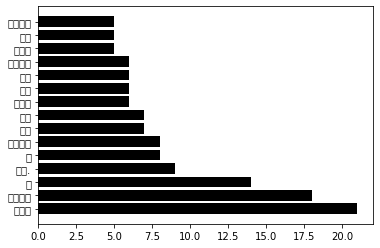

In [162]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumMyeongjo')
plt.barh(range(len(v)), v, color = 'black')
plt.yticks(range(len(v)), k)
plt.show()

'Nanum' 또는 'Myeongjo' 한글 폰트가 설치되었는지 확인하고, 그 중의 적당한 폰트를 사용하자.

In [164]:
from matplotlib import font_manager
for font in font_manager.fontManager.ttflist:
    if 'Nanum' in font.name:
        print(font.name, font.fname)

NanumGothic C:\Windows\Fonts\BOLD.TTF
NanumGothic C:\WINDOWS\Fonts\.TTF
NanumGothic C:\WINDOWS\Fonts\EXTRABOLD.TTF


#### combineByKey

앞서 사용했던 데이터로 combineByKey()를 사용해 보자. 키별로 합계 및 갯수 ```(key, (sum, count))```를 계산한다.

구분 | combiner | merge values | merge combiner
-----|-----|-----|-----
설명 | 각 키에 대해 **```(value,1)```** 튜플 만든다 | 값을 더해나감 (sum,count)<br>즉, **```sum+value```**,**```count+1```** | partition별로 combiner를 더함

* **데이터 생성**

앞서 ```_testRdd```를 사용해서 combineByKey()를 해보자.

In [11]:
_testList=[("key1",1),("key1",3),("key2",2),("key1",2),("key2",4),
           ("key1",5),("key2",6),
           ("key1",7),("key1",8),("key2",9),("key2",3)]

* **partition이 1개이면 combiner, mergeValues만 작동**

partition이 1개인 경우를 먼저 해보자. Rdd를 생성하자.

In [12]:
_testRdd=spark.sparkContext.parallelize(_testList)

현재 partition은 1개이다.

In [13]:
_testRdd.getNumPartitions()

1

partition이 1개이면 키별로 값을 더해간다. 키가 존재하지 않으면 combiner()를, 존재하면 mergeValues()가 실행된다.
* (key1, 1) key1은 처음 등장하는 키이므로 accumulator[key1] = createCombiner(1)
* (key1, 3) key1은 존재하는 키이므로 accumulator[key1] = mergeValue(accumulator[key1], 3)
* (key2, 2) key2는 처음 등장하는 키이므로 accumulator[key2] = createCombiner(2)
* (key1, 2) key1은 존재하는 키이므로 accumulator[key1] = mergeValue(accumulator[key1], 2)
* ...

아래 출력결과를 해석해보자.
key1의 값은 1,3,2,4,7,8이고 key2의 값은 2,4,6,9,3이다.
앞서 설명대로:
* key1의 첫째 값은 1이다. 이경우 combiner (```*```표기), 다음은 merge values (```#``` 표기)로 계산이 된다. 따라서 ```1*#3#2#5#7#8```가 출력된다.
* key2는 ```2*#4#6#9#3```가 출력된다.

In [14]:
_testRdd.combineByKey(lambda v : str(v)+"*", lambda c, v : c+"#"+str(v), lambda c1, c2 : c1+'&'+c2).collect()

[('key1', '1*#3#2#5#7#8'), ('key2', '2*#4#6#9#3')]

* **partition이 복수이면 mergeCombiner가 작동**

partition이 복수인 경우에는 mergeCombiner가 작동한다. 먼저 partition을 2개로 해서 Rdd를 생성하자.

In [15]:
_testRdd=spark.sparkContext.parallelize(_testList, 2)

In [16]:
partitions = _testRdd.glom().collect()
for num, partition in enumerate(partitions):
    print(f'Partitions {num} -> {partition}')

Partitions 0 -> [('key1', 1), ('key1', 3), ('key2', 2), ('key1', 2), ('key2', 4)]
Partitions 1 -> [('key1', 5), ('key2', 6), ('key1', 7), ('key1', 8), ('key2', 9), ('key2', 3)]


partition이 분할 되었으므로, partition별로 합산된다.
* key1은 partition 0에서 1,3,2 그리고 partition 1에서 5,7,8이 연산된다. 그 결과 ```1*#3#2&5*#7#8```
* key2는 2,4,6과 6,9,3이 각 각 다른 partition에서 연산되어 ```2*#4&6*#9#3```이 출력된다.

In [17]:
_testRdd.combineByKey(lambda v : str(v)+"*", lambda c, v : c+"#"+str(v), lambda c1, c2 : c1+'&'+c2).collect()

[('key1', '1*#3#2&5*#7#8'), ('key2', '2*#4&6*#9#3')]

* **실제 해보기**

앞서 사용했던 기호를 연산자로 변경해서, 실제 해보자.
그 결과는 합계, 개수를 구할 수 있게 된다.

In [18]:
_testRdd.combineByKey(lambda value: (value,1),
                     lambda x,value: (x[0]+value, x[1]+1),
                     lambda x,y: (x[0]+y[0], x[1]+y[1])) \
        .collect()

[('key1', (26, 6)), ('key2', (24, 5))]

* **평균 계산**

combineByKey()함수로 **sum**, **count**를 구하게 된다. 그리고 map()함수로 **sum/count**를 계산하게 된다.

In [19]:
_testCbkRdd=_testRdd.combineByKey(lambda value: (value,1),
                     lambda x,value: (x[0]+value, x[1]+1),                      
                     lambda x,y: (x[0]+y[0], x[1]+y[1]))

과거에는 아래와 같이 lambda 함수의 인자를 별도로 3개 받았으나, 지금은 하나를 받도록 프로그램하자.

```python
averageByKey = _testCbkRdd.map(lambda (key,(sum,count)):(key,float(sum)/count))
averageByKey.collectAsMap()
```

In [20]:
averageByKey = _testCbkRdd.map(lambda x:(x[0],x[1][0]/x[1][1]))
averageByKey.collectAsMap()

{'key1': 4.333333333333333, 'key2': 4.8}

#### combineByKey 예제

* combineByKey(x, y, z) - groupByKey()는 값 합계를 미리 계산하지 때문에 비효율적이다.
* partition별로 무작위 배분되어 실행되나, 아래는 하나의 partition을 가정하고 예제를 설명한다.
    * partition A: ('kim',86),('lim',87),('kim',91),('lim',79)
    * partition B: ('kim',75),('lim',78),('lim',92),('lee',99)

구분 | 함수명 | 설명
-----|-----|-----
x | Combiner 함수 | 값을 combine (V) -> C 예: (value,1)
y | Merge value 함수 | 값을 merge (C, V) -> C 예: (sum,count)
z | Merge combiners 함수 | combiner를 merge (C, C) -> C) 예: (K, C)

데이터 | 적용 함수 | 결과
-----|-----|-----
('kim',86) | combiner | accum[kim],(86,1)
('lim',87) | combiner | accum[lim],(87,1)
('kim',75) | merge value | (accum[kim],75) -> accum[kim],(86+75,1+1) = (161,2)
('kim',91) | merge value | (accum[kim],91) -> (161+91,2+1) = (252,3)
('lim',78) | merge value | (accum[lim],78) -> (87+78,1+1) = (165,2)
('lim',92) | merge value | (accum[lim],92) -> (165+92,2+1) = (257,3)
('lim',79) | merge value | (accum[lim],79) -> (257+79,3+1) = (336,4)
('lee',99) | combiner | accum[lee],(99,1)
partition별 합산 | merge combiners | [('lim', (336, 4)), ('lee', (99, 1)), ('kim', (252, 3))


In [21]:
marks = spark.sparkContext.parallelize([('kim',86),('lim',87),('kim',75),
                                      ('kim',91),('lim',78),('lim',92),
                                      ('lim',79),('lee',99)])

In [22]:
marksByKey = marks.combineByKey(lambda value: (value,1),
                             lambda x,value: (x[0]+value, x[1]+1),
                             lambda x,y: (x[0]+y[0], x[1]+y[1]))

In [23]:
marksByKey.collect()

[('kim', (252, 3)), ('lim', (336, 4)), ('lee', (99, 1))]

In [24]:
heights = spark.sparkContext.parallelize([
        ('M',182.),('F',164.),('M',180.),('M',185.),('M',171.),('F',162.)
    ])

In [25]:
heightsByKey = heights.combineByKey(lambda value: (value,1),
                             lambda x,value: (x[0]+value, x[1]+1),
                             lambda x,y: (x[0]+y[0], x[1]+y[1]))

In [26]:
heightsByKey.collect()

[('M', (718.0, 4)), ('F', (326.0, 2))]

In [27]:
avgByKey = heightsByKey.map(lambda x: (x[0],x[1][0]/x[1][1]))

print (avgByKey.collectAsMap())

{'M': 179.5, 'F': 163.0}


## 문제 S-3: 성적 합계 및 평균.

아래 데이터를 RDD로 만들고, 성적의 합계 및 평균을 계산하세요.
하위 문제별로 RDD를 생성하지 말고, 원본데이터에서 하나의 RDD만을 생성하고, 이를 변형해서 문제를 푸세요.

이름 | 과목 | 점수
-----|-----|-----
김하나 | English | 100
김하나 | Math | 80
임하나 | English | 70
임하나 | Math | 100
김갑돌 | English | 82.3
김갑돌 | Math | 98.5

* 문제 3-1: 이름으로 합계를 구해보자. 올바른 출력은 다음과 같다.
**이름과 점수로 데이터를 추출**하고, **이름별로 (이름을 키로)** 합계를 계산한다.

```python
'임하나' 170.0
'김하나' 180.0
'김갑돌' 180.8
```
* 문제 3-2: 과목으로 합계를 계산해 보자. 출력은 다음과 같이 나와야 한다.
**과목과 점수로 데이터를 추출**하여, **과목별로 (과목을 키로)** 합계를 계산한다.

```python
'English' 252.3
'Math' 278.5
```

* 문제 3-3: 이름으로 합계과 개수를 구해보자. 출력은 다음과 같이 계산된다.
**이름과 점수로 데이터를 추출**하여, **이름별로 (이름을 키로)** 합계와 개수를 계산한다.

```python
'임하나' (170.0, 2)
'김하나' (180.0, 2)
'김갑돌' (180.8, 2)
```

* 문제 3-4: 이름으로 평균을 계산해 보자. 앞서 3-3에서 사용했던 결과를 활용하고, 올바른 출력은 다음과 같다.

```python
'임하나' 85.0
'김하나' 90.0
'김갑돌' 90.4
```


### RDD 생성

우선 데이터를 만들어 보자. 이름, 과목, 성적을 개인별로 넣어 2차원 리스트로 만들어졌다.

In [28]:
marks=[
    "'김하나','English', 100",
    "'김하나','Math', 80",
    "'임하나','English', 70",
    "'임하나','Math', 100",
    "'김갑돌','English', 82.3",
    "'김갑돌','Math', 98.5"
]
_marksRdd=spark.sparkContext.parallelize(marks)

### 문제 3-1

개인별 데이터를 컴마로 분리하고, 이름 x[0]과 성적 x[2]만 꺼내어 reduceBykey()를 구하면 합계를 구할 수 있다.
여기서 중요한 것은 기존 데이터에서 필요한 이름, 성적만을 꺼내어 처리한다는 점이다.

In [29]:
# marks by name
_marksbyname=_marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[0],float(x[2])))\
    .reduceByKey(lambda x,y:x+y)\
    .collect()

In [30]:
for i in _marksbyname:
  print (i[0],i[1])

'김하나' 180.0
'임하나' 170.0
'김갑돌' 180.8


### 문제 3-2

개인별 데이터를 컴마로 분리하고, 과목 x[1]과 성적 x[2]만 꺼내어 reduceBykey()를 구하면 합계를 구할 수 있다.

In [31]:
# marks by subject
_marksbysubject=_marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[1],float(x[2])))\
    .reduceByKey(lambda x,y:x+y)\
    .collect()
for i in _marksbysubject:
  print (i[0],i[1])

'English' 252.3
'Math' 278.5


### 문제 3-3

합계, 개수를 계산해 보자. combineByKey()를 이용해서 계산해야 한다.
먼저 데이터를 **이름, 과목, 데이터** -> **이름, 점수**로 변경한다.

In [32]:
# marks by name
_marksbyname2=_marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[0],float(x[2])))

In [33]:
# sum, counts by name
sum_counts = _marksbyname2.combineByKey(
    (lambda x: (x, 1)), # the initial value, with value x and count 1
    (lambda acc, value: (acc[0]+value, acc[1]+1)), # how to combine a pair value with the accumulator: sum value, and increment count
    (lambda acc1, acc2: (acc1[0]+acc2[0], acc1[1]+acc2[1])) # combine accumulators
)

In [34]:
for i in sum_counts.collect():
    for each in i:
        print (each, end=' ')
    print()

'김하나' (180.0, 2) 
'임하나' (170.0, 2) 
'김갑돌' (180.8, 2) 


### 문제 3-4

개인별 평균은 3-3에서 구했던 합계, 개수를 사용하여 계산한다.
평균을 계산하기 위해 float() 형변환을 해주었다.

In [35]:
# average
averageByKey = sum_counts\
    .map(lambda x: (x[0],x[1][0]/x[1][1]))\
    .collect()
for i in averageByKey:
    for j in i:
        print (j, end=' ')
    print()

'김하나' 90.0 
'임하나' 85.0 
'김갑돌' 90.4 


## 문제 S-4: 서울시 지하철호선별 승차인원 평균 구하기.

### 문제

정량데이터는 보통 집단화하여 빈도, 평균, 합계 등 서술통계를 계산한다.
서울시 지하철호선별 역별 승하차 인원 정보를 가져와 평균을 구해보자.
* 파일 명 CARD_SUBWAY_MONTH_201501.csv를 다운로드 받아서 일부만 테스트용 데이터로 사용한다.
* 오픈API 샘플URL http://openapi.seoul.go.kr:8088/(인증키)/xml/CardSubwayStatsNew/1/5/20151101

### 해결

PairRDD를 사용한다.
답
[('2호선', 10529.0),
 ('3호선', 9236.0),
 ('4호선', 5704.0),
 ('경부선', 19989.6),
 ('경원선', 1194.75)]

### RDD 생성

* 2015년 1월 csv파일의 일부를 가져와서 리스트를 생성한다.
* 데이터 헤더: "사용일자","노선명","역ID","역명",승차총승객수,하차총승객수

In [ ]:
_sub=["20150101,2호선,0236,영등포구청,6199,6219",
"20150101,2호선,0237,당산,7982,8946",
"20150101,2호선,0238,합정,17406,15241",
"20150101,3호선,0309,지축,515,538",
"20150101,3호선,0310,구파발,6879,6260",
"20150101,3호선,0311,연신내,20031,19470",
"20150101,3호선,0312,불광,9519,11029",
"20150101,4호선,0425,회현,7465,7574",
"20150101,4호선,0426,서울역,3943,10823",
"20150101,경부선,1002,남영,4340,4535",
"20150101,경부선,1003,용산,28980,27684",
"20150101,경부선,1004,노량진,23021,23862",
"20150101,경부선,1005,대방,6360,6476",
"20150101,경부선,1006,영등포,37247,36102",
"20150101,경원선,1008,이촌,1940,1507",
"20150101,경원선,1009,서빙고,911,1000",
"20150101,경원선,1010,한남,1885,1863",
"20150101,경원선,1011,옥수,43,37"]


In [ ]:
_subRdd = spark.sparkContext.parallelize(_sub)

In [ ]:
for i in _subRdd.take(1):
    print (i)

### 데이터 정리

* map()을 사용해서 컴마를 제외할 수 있다.

In [ ]:
for i in _subRdd.map(lambda x:x.split(',')).collect():
    for j in i:
        print (j, end=" ")
    print()

* 호선별 데이터 개수를 출력해 본다.
* map()의 **3번째 인덱스는 앞에서부터 4번째 철자**를 출력한다.
* 컴마로 분리해서 인덱스를 사용해야 제대로 데이터를 출력한다.

In [ ]:
_subRdd.map(lambda x:int(x[3])).collect()

In [ ]:
_subRdd.map(lambda x:x.split(',')).map(lambda x:int(x[4])).collect()

### 총 승차인원의 합계를 reduce()로 합산한다.

* reduce()함수는 인자를 2개 받아서 합계를 구한다.

In [ ]:
_subRdd.map(lambda x:x.split(',')).map(lambda x:(int(x[4]))).reduce(lambda x,y:x+y)

### 호선별 승차인원 평균을 계산한다.

* Pair RDD를 사용하므로, 사전에 데이터를 (호선, 승차인원) 형식으로 구성한다.

In [ ]:
_subLineByPassengers=_subRdd.map(lambda x:x.split(',')).map(lambda x: (x[1],int(x[4])))
sum_counts = _subLineByPassengers.combineByKey(
    (lambda x: (x, 1)), # the initial value, with value x and count 1
    (lambda acc, value: (acc[0]+value, acc[1]+1)), # how to combine a pair value with the accumulator: sum value, and increment count
    (lambda acc1, acc2: (acc1[0]+acc2[0], acc1[1]+acc2[1])) # combine accumulators
)

In [ ]:
for i in sum_counts.collect():
    for each in i:
        print (each, end=" ")
    print()

In [ ]:
for i in sum_counts.collect():
    print (i[0],i[1][0],i[1][1])

* 위와 달리 map()을 사용하여 평균을 계산한다.

In [ ]:
averageByKey = sum_counts.map(lambda x: (x[0],x[1][0]/x[1][1]))

In [ ]:
averageByKey.collect()

## S.7 spark-submit

Spark를 설치하면, 일괄실행할 수 있는 ```spark-submit``` 명령어가 따라온다.
따라서 별도의 sys.path 설정은 하지 않아도 된다.

### log 설정
spark-submit을 실행하면 로그가 출력되는데, 그 양이 상당하다.
spark-submit을 실행하기 전, 'conf/log4j.properties'를 수정 log level을 ERROR로 설정하자.

spark가 설치된 디렉토리에서 ```conf/```로 이동하자.
그 디렉토리에서 log4j.properties.templates를 찾아서, 아래 줄을 찾아 수정하자.

```python
log4j.rootCategory=ERROR, console
```

### python 버전 설정
You can set the PYSPARK_PYTHON variable in conf/spark-env.sh (in Spark's installation directory) to the absolute path of the desired Python executable.

Spark distribution contains spark-env.sh.template (spark-env.cmd.template on Windows) by default. It must be renamed to spark-env.sh (spark-env.cmd) first.

For example, if Python executable is installed under /opt/anaconda3/bin/python3:

* Python 파일의 encoding 선언
    * 기본 설정은 7-bit ASCII
```python
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
```

In [ ]:
%%writefile src/ds_spark_rdd_hello.py
#!/usr/bin/env python3
# -*- coding: UTF-8 -*-
import pyspark
def doIt():
    print ("---------RESULT-----------")
    print (spark.version)
    spark.conf.set("spark.logConf","false")
    rdd=spark.sparkContext.parallelize(range(1000), 10)
    print ("mean=",rdd.mean())
    nums = spark.sparkContext.parallelize([1, 2, 3, 4])
    squared = nums.map(lambda x: x * x).collect()
    for num in squared:
        print ("{} ".format(num))

if __name__ == "__main__":
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()
    doIt()
    spark.stop()


In [ ]:
!spark-submit src/ds_spark_rdd_hello.py

In [ ]:
!/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/bin/spark-submit src/ds_spark_rdd_hello.py

In [ ]:
%%writefile src/ds_spark_rdd_reduceBykey.py
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
import pyspark
import os
def doIt():
    print "---------RESULT-----------"
    myRdd=spark.sparkContext\
        .textFile(os.path.join("data","ds_spark_wiki.txt"))
    res=myRdd\
        .flatMap(lambda x:x.split())\
        .map(lambda x:(x,1))\
        .reduceByKey(lambda x,y:x+y)\
        .map(lambda x:(x[1],x[0]))\
        .sortByKey(False)\
        .take(10)
    for i in res:
        print i

if __name__ == "__main__":
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()
    doIt()
    spark.stop()


In [ ]:
!/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/bin/spark-submit src/ds_spark_rdd_reduceBykey.py

## 문제 S-4: RDD를 사용하여 word vector를 생성하기.

### 문제
사람은 연설이나 에세이 등을 읽고 나면 그 내용이 무엇이고 무엇을 말하려고 하는지 알 수 있다. 주제가 무엇이고 심지어는 숨겨진 행간도 이해할 수 있다.
그러나 컴퓨터는 문서를 읽고 의미를 파악해 내는 것이 쉽지 않다.
그 대신 문서에 어떤 단어가 쓰였고, 많이 쓰인 단어가 무엇인지 알아내어 어떤 내용인지 알아내게 된다.
이 경우 쓰인 단어의 빈도를 **word vector**라고 하며, 문서로 부터 이를 만들어 내는 작업이 필요하다.

> **Bag of words** 모델
> 
> 문서 또는 문장을 단어의 집합 "bag of words"으로 표현한다. 단어가 쓰인 순서나 문법은 무시한다.
> 다음 문장은 단어와 그 횟수로 표현할 수 있다.

> 문장 | 단어 | bag of words 표현
> -----|-----|-----
> I like to play football. | I, like, to, play, football | {"I":1, "like":1, "to":1, "play":1, "football":1}
> He also likes to play football. | He, also, likes, to, play, football | {"He":1, "also":1, "likes":1, "to":1, "play":1, "football":1}

### 해결

분석하려는 문서를 RDD로 만들고, map-reduce 알고리듬으로 단어의 빈도를 계산할 수 있다.
```Spark mllib``` 라이브러리에서는 자연어처리 기법을 제공하고 있다.
TF-IDF, Word2Vec 등을 사용하면 단어의 빈도 및 관련어 등을 분석해 낼 수 있다.
다음 장에서 배우겠지만 데이터프레임을 생성하고 ml 라이브러를 사용할 수도 있다.
ml은 DataFrame을 위한 라이브러리로서 Tokenizer, Stopwords, NGram 등을 분석할 수도 있다.

### RDD 생성

파일 전체를 읽어서, 단어의 수를 세어 본다.

줄 | 설명
-----|-----
1 | sparkContext.textFile()로 파일을 읽어 RDD로 만든다.
2 | flatMap()을 으로 공백으로 분리하여 RDD를 생성한다. 이러한 변환은 실제 연산까지 일어나지 않는다, 즉 lazy변환이다.

파일은 이미 만들어 놓은 wiki를 사용한다. 아래와 같이 파일이 있는지 확인해 본다.

In [ ]:
!ls data/ds_spark_wiki.txt

RDD를 생성해보자. 문서파일은 문장으로 이루어져 있고, 이를 기준으로 word vector를 구성할 수 있다.
그러나 문서 **전체**를 word vector로 표현하려면 **flatMap()** 함수를 사용해야 한다.

In [ ]:
import os
wikiRdd=spark.sparkContext.textFile(os.path.join("data","ds_spark_wiki.txt"))

### 단어집합

문장을 split()으로 분리하여 단어의 집합으로 만든다. 리스트를 모두 1차원으로 만드는 flatMap() 함수를 사용한다.

In [ ]:
words=wikiRdd\
    .flatMap(lambda x: x.split())

아직 중간과정이므로 PipelineRDD가 만들어졌다.

In [ ]:
print (type(words))

단어의 개수는 count() 함수로 알 수 있다.

In [ ]:
print ("단어 갯수: ", words.count())

앞서 분리된 단어를 collect()함수로 취합한다.
**collect() 결과는 list**로 만들어 진다.
모든 항목을 출력하려면 list의 인덱스 [:]를 사용한다.
유니코드를 지원하므로, 한글이 잘 출력되고 있다.

In [ ]:
print ("전체 단어: ", words.collect()[0:72])

### 단어빈도

이제 map-reduce를 같이 사용하여 단어를 세어 tuple로 만들어 보자.
flatMap()은 앞서 설명한 바와 같이 파일 텍스트를 공백으로 분리한다.
map()함수는 모든 단어에 대해 소문자로 만들고, **불필요한 구문 (new lines, commas, periods)을 제거**한 후 tuple로 만든다.

문자열  양끝에 붙어있을 수 있는 문자를 ```rstrip()```으로 제거한다. 매개변수가 없으면 whitespace를 제거한다.

함수 | 설명
-----|-----
rstrip() | 꼬리에 붙는 문자를 제거
lstrip() | 머리에 붙는 문자를 제거

즉 **(단어, 1) 구조**로 만들어 **같은 단어는 나중에 서로 더할 수** 있게 만들어 놓는다.

In [ ]:
#from operator import add
wc = spark.sparkContext.textFile(os.path.join("data","ds_spark_wiki.txt"))\
    .flatMap(lambda x: x.split())\
    .map(lambda x: (x.lower().rstrip().lstrip().rstrip(',').rstrip('.'), 1))

아직 단어별로 갯수를 계산하지 않았기 때문에, 모두 1인 값을 가진다.
sortByKey()는 **올림차순**을 기본으로 정렬한다.

In [ ]:
wc.sortByKey().take(5)

### 빈도 집계

이제 단어의 갯수를 합계내어 보자. 아래 방법 모두 **동일한 결과를 산출**한다.

구분 | 설명
-----|-----
```reduceByKey(add)``` | ```add``` operator를 사용하면, 단어튜플의 수를 키별로 더할 수 있다.
```groupByKey().mapValues(sum)``` | ```mapValues()```를 사용하여 value의 'sum'을 계산할 수 있다.
```groupByKey().map(lambda (x,iter): (x,len(iter)))``` | (key,value)의 구조를 사용하여 합계를 계산할 수 있다.

### 하나. reduceByKey()

Python의 연산자 add() 함수를 사용해서 할 수 있다.
**operator.add()**는 reduce()함수의 숫자 인자 x,y를 받아서 x+y 연산을 한다.

In [ ]:
from operator import add
wcReduceByKey = wc.reduceByKey(add)

In [ ]:
wcReduceByKey.sortByKey().take(10)

또는 add대신에 reduceByKey()에 lambda함수를 사용해도 된다.

In [ ]:
wcReduceByKey = wc.reduceByKey(lambda x,y:x+y)

In [ ]:
wcReduceByKey.sortByKey().take(10)

In [ ]:
import os
wikiRdd=spark.sparkContext.textFile(os.path.join("data","ds_spark_wiki.txt"))

wc=wikiRdd\
    .flatMap(lambda x: x.split())\
    .map(lambda x: (x.lower().rstrip().lstrip().rstrip(',').rstrip('.'), 1))\
    .reduceByKey(lambda x,y:x+y)

In [ ]:
wcReduceByKey.sortByKey().take(10)

### 둘. groupByKey(), mapValues()

groupByKey()는 단어키로 동일한 단어는 집단화한다.
집단화 하면 **PairRDD가 되고, 즉 key-value 쌍**으로 구성된다.
**mapValues()는 각 쌍의 value에 대해서 sum 연산**을 한다.

In [ ]:
wcGroupByKey = wc.groupByKey().mapValues(sum)

In [ ]:
wcGroupByKey.sortByKey().take(10)

### 셋. groupByKey(), map, len

mapValues()를 사용하지 않고 map()으로 **len()**갯수를 세어도 동일한 결과를 얻을 수 있다.
**단어별로 1개씩 만들어 놓았으므로 len()으로 세면 단어갯수의 합계**가 된다.

전에는 ```wc.groupByKey().map(lambda (x,v): (x,len(v)))```

In [ ]:
wcGroupByKey2 = wc.groupByKey().map(lambda x: (x[0],len(x[1])))

In [ ]:
wcGroupByKey2.sortByKey().take(10)

### 넷. 줄로 구분하여 단어 빈도

```flatMap()```을 사용하지 않으면 **줄로 구분하여 단어 빈도**를 셀 수 있다.
줄로 구분하여 리스트를 만들게 되므로, 결과는 2차원 리스트가 된다.

줄 | 설명
-----|-----
1 | ```sparkContext.textFile()``` 파일을 읽어 RDD 생성
2 | 불필요한 컴마, 점, 하이픈을 제거하고 소문자로
3 | 공백으로 분리
4 | 반복문으로 단어별 튜플구조화

In [ ]:
wc = spark.sparkContext.textFile("data/ds_spark_wiki.txt")\
    .map(lambda x: x.replace(',',' ').replace('.',' ').replace('-',' ').lower())\
    .map(lambda x:x.split())\
    .map(lambda x:[(i,1) for i in x])

In [ ]:
for e in wc.collect():
    print (e)

### 묶어서

지금까지의 작업을 프로그램으로 묶어보면 다음과 같다.

In [ ]:
%%writefile src/ds_rdd_wordCount.py
#!/usr/bin/env python
# -*- coding: UTF-8 -*-

import pyspark
import os

def doIt():
    wikiRdd=spark.sparkContext.textFile(os.path.join("data","ds_spark_wiki.txt"))
    wc=wikiRdd\
        .flatMap(lambda x: x.split())\
        .map(lambda x: (x.lower().rstrip().lstrip().rstrip(',').rstrip('.'), 1))\
        .reduceByKey(lambda x,y:x+y)\
        .sortByKey()\
        .collect()
    for w in wc:
        print (w)

if __name__ == "__main__":
    os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
    os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()
    doIt()
    spark.stop()


In [ ]:
!spark-submit src/ds_rdd_wordCount.py